In [1]:
import re
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
#plt.style.use('seaborn')
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report   
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from datetime import datetime

# Predicting if an MTA(Metropolitan Transportation Authority) Bus Will Be Late.

## Introduction 

Metropolitan Transportation Authority(MTA) buses in New York city are notorious for being slow and late. For this project we will take a look at a data set from Kaggle and see how accurately we can determine if a bus is going to be late or not. A useful model will be able to be interpreted so that solutions can be developed to improve the bus service performance but we will also be trying to see how accurate wecan get the predictions. 

In [2]:
 # Load data 
#mta = pd.read_csv('C:/Users/keith/Desktop/Thinkful/mta_1706.csv',encoding = "ISO-8859-1",error_bad_lines=False)
mta_bus = pd.read_csv('C:/Users/keith/Desktop/Thinkful/mta_1706_1.csv',encoding = "ISO-8859-1",error_bad_lines=False)
pd.set_option('display.max_columns', 50)

b'Skipping line 53192: expected 17 fields, saw 18\nSkipping line 56712: expected 17 fields, saw 18\nSkipping line 64874: expected 17 fields, saw 18\n'
b'Skipping line 80636: expected 17 fields, saw 18\nSkipping line 97072: expected 17 fields, saw 18\n'
b'Skipping line 107697: expected 17 fields, saw 18\nSkipping line 109317: expected 17 fields, saw 18\nSkipping line 119951: expected 17 fields, saw 18\n'
b'Skipping line 134667: expected 17 fields, saw 18\nSkipping line 139923: expected 17 fields, saw 18\nSkipping line 144309: expected 17 fields, saw 18\nSkipping line 157927: expected 17 fields, saw 18\nSkipping line 158907: expected 17 fields, saw 18\nSkipping line 161424: expected 17 fields, saw 18\n'
b'Skipping line 173221: expected 17 fields, saw 18\nSkipping line 173623: expected 17 fields, saw 18\nSkipping line 177253: expected 17 fields, saw 18\nSkipping line 181883: expected 17 fields, saw 18\nSkipping line 186684: expected 17 fields, saw 18\nSkipping line 191267: expected 17 fie

b'Skipping line 2831078: expected 17 fields, saw 18\nSkipping line 2831884: expected 17 fields, saw 18\nSkipping line 2832778: expected 17 fields, saw 18\n'
b'Skipping line 2935466: expected 17 fields, saw 18\nSkipping line 2937968: expected 17 fields, saw 18\n'
b'Skipping line 2952504: expected 17 fields, saw 18\n'
b'Skipping line 2982958: expected 17 fields, saw 18\nSkipping line 2991335: expected 17 fields, saw 18\nSkipping line 3006710: expected 17 fields, saw 18\nSkipping line 3013361: expected 17 fields, saw 18\n'
b'Skipping line 3019557: expected 17 fields, saw 18\nSkipping line 3032671: expected 17 fields, saw 18\n'
b'Skipping line 3068454: expected 17 fields, saw 18\nSkipping line 3079236: expected 17 fields, saw 18\n'
b'Skipping line 3081942: expected 17 fields, saw 18\nSkipping line 3095240: expected 17 fields, saw 18\n'
b'Skipping line 3166450: expected 17 fields, saw 18\nSkipping line 3178126: expected 17 fields, saw 18\n'
b'Skipping line 3192452: expected 17 fields, saw 1

b'Skipping line 5158386: expected 17 fields, saw 18\n'
b'Skipping line 5278636: expected 17 fields, saw 18\n'
b'Skipping line 5389023: expected 17 fields, saw 18\nSkipping line 5393062: expected 17 fields, saw 18\n'
b'Skipping line 5410409: expected 17 fields, saw 18\n'
b'Skipping line 5444054: expected 17 fields, saw 18\n'
b'Skipping line 5496628: expected 17 fields, saw 18\nSkipping line 5496629: expected 17 fields, saw 18\n'
b'Skipping line 5510776: expected 17 fields, saw 18\n'
b'Skipping line 5548626: expected 17 fields, saw 18\nSkipping line 5551773: expected 17 fields, saw 18\nSkipping line 5556312: expected 17 fields, saw 18\nSkipping line 5570453: expected 17 fields, saw 18\n'
b'Skipping line 5577387: expected 17 fields, saw 18\nSkipping line 5580723: expected 17 fields, saw 18\nSkipping line 5582075: expected 17 fields, saw 18\nSkipping line 5596334: expected 17 fields, saw 18\nSkipping line 5602325: expected 17 fields, saw 18\n'
b'Skipping line 5606005: expected 17 fields, s

I am only going to use a sample of the data. 

In [3]:
#take sample because the full set is too much to try to analyze on local machine
mta = mta_bus.sample(n=200000,random_state=20)

# Data Description

This dataset was pulled from Kaggle and can be found here: https://www.kaggle.com/stoney71/new-york-city-transport-statistics. The data was collected from MTA SIRI Real Time data feed and the MTA GTFS Schedule data. It contains 6.73 million rows of data and 17 feature columns. It is a mixture of categorical and continuous variables such route names, bus stops, and distances the bus is from the bus stop when recorded. There is also geospacial data of the the location of the bus and well as the time the bus will reach the stop. The recordings are taken every 10 minutes. 

In [4]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
249431,2017-06-02 00:05:00,1,Q17,138 ST/37 AV,40.761806,-73.829559,JAMAICA ARCHER AV,40.704933,-73.793320,NYCT_8442,40.712529,-73.784314,HILLSIDE AV/EDGERTON BL,approaching,128.0,NaN,23:58:34
5083624,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,16:26:16
2001707,2017-06-09 17:38:05,1,Bx9,NaN,NaN,NaN,WEST FARMS,40.840641,-73.879807,NYCT_1214,40.879992,-73.904038,BROADWAY/W 231 ST,approaching,120.0,2017-06-09 17:39:19,NaN
2315680,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,14:59:05
2230060,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,22:21:22


In [5]:
 mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 249431 to 4007649
Data columns (total 17 columns):
RecordedAtTime               200000 non-null object
DirectionRef                 200000 non-null int64
PublishedLineName            200000 non-null object
OriginName                   198089 non-null object
OriginLat                    198089 non-null float64
OriginLong                   198089 non-null float64
DestinationName              200000 non-null object
DestinationLat               199706 non-null float64
DestinationLong              199706 non-null float64
VehicleRef                   200000 non-null object
VehicleLocation.Latitude     200000 non-null float64
VehicleLocation.Longitude    200000 non-null float64
NextStopPointName            199799 non-null object
ArrivalProximityText         199799 non-null object
DistanceFromStop             199799 non-null float64
ExpectedArrivalTime          173610 non-null object
ScheduledArrivalTime         194797 non-null 

In [6]:
mta.shape

(200000, 17)

# Data cleaning

In [7]:
mta.duplicated().sum()

0

In [8]:
#pd.set_option('display.max_columns', None) # disables trucated columns 
#pd.set_option('display.max_rows', None) # disables trucated rows
mta.head()   

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
249431,2017-06-02 00:05:00,1,Q17,138 ST/37 AV,40.761806,-73.829559,JAMAICA ARCHER AV,40.704933,-73.793320,NYCT_8442,40.712529,-73.784314,HILLSIDE AV/EDGERTON BL,approaching,128.0,NaN,23:58:34
5083624,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,16:26:16
2001707,2017-06-09 17:38:05,1,Bx9,NaN,NaN,NaN,WEST FARMS,40.840641,-73.879807,NYCT_1214,40.879992,-73.904038,BROADWAY/W 231 ST,approaching,120.0,2017-06-09 17:39:19,NaN
2315680,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,14:59:05
2230060,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,22:21:22


In [9]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime'],
      dtype='object')

In [10]:
mta.columns=['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime']

In [11]:
mta.isnull().sum()

RecordedAtTime              0
DirectionRef                0
PublishedLineName           0
OriginName               1911
OriginLat                1911
OriginLong               1911
DestinationName             0
DestinationLat            294
DestinationLong           294
VehicleRef                  0
VehicleLocation_Lat         0
VehicleLocation_Long        0
NextStopPointName         201
ArrivalProximityText      201
DistanceFromStop          201
ExpectedArrivalTime     26390
ScheduledArrivalTime     5203
dtype: int64

In [12]:
# check to see what percentage of data will be lost if all null values are dropped
(mta.isnull().sum()/mta.isnull().count()*100).astype(str)+" %"

RecordedAtTime                         0.0 %
DirectionRef                           0.0 %
PublishedLineName                      0.0 %
OriginName              0.9554999999999999 %
OriginLat               0.9554999999999999 %
OriginLong              0.9554999999999999 %
DestinationName                        0.0 %
DestinationLat                       0.147 %
DestinationLong                      0.147 %
VehicleRef                             0.0 %
VehicleLocation_Lat                    0.0 %
VehicleLocation_Long                   0.0 %
NextStopPointName                   0.1005 %
ArrivalProximityText                0.1005 %
DistanceFromStop                    0.1005 %
ExpectedArrivalTime                 13.195 %
ScheduledArrivalTime                2.6015 %
dtype: object

We need to drop the rows with missing arrival times. It is usless to us if we can't find the bus is late or not.

In [13]:
mta = mta[mta.ExpectedArrivalTime.isnull()==False]  
mta.isnull().sum()
 

RecordedAtTime             0
DirectionRef               0
PublishedLineName          0
OriginName              1623
OriginLat               1623
OriginLong              1623
DestinationName            0
DestinationLat           221
DestinationLong          221
VehicleRef                 0
VehicleLocation_Lat        0
VehicleLocation_Long       0
NextStopPointName          0
ArrivalProximityText       0
DistanceFromStop           0
ExpectedArrivalTime        0
ScheduledArrivalTime    1623
dtype: int64

In [14]:
mta = mta[mta.ScheduledArrivalTime.isnull()==False]
mta.isnull().sum()

RecordedAtTime          0
DirectionRef            0
PublishedLineName       0
OriginName              0
OriginLat               0
OriginLong              0
DestinationName         0
DestinationLat          0
DestinationLong         0
VehicleRef              0
VehicleLocation_Lat     0
VehicleLocation_Long    0
NextStopPointName       0
ArrivalProximityText    0
DistanceFromStop        0
ExpectedArrivalTime     0
ScheduledArrivalTime    0
dtype: int64

In [15]:
len(mta)/200000

0.859935

In [16]:
# reindex dataset
mta.index = range(len(mta.index))

That took care of all of our null values, that we can tell anyway.

Next we need to create a target variable. We are trying to predict if a bus is going to be late or not so we will convert the time rows in to manageable data and the find the difference in times.

In [17]:
# modifying "ScheduledArrivalTime" format to match "EstimatedArrivalTime"
mta.loc[list(np.where(mta.ScheduledArrivalTime=='24:00:00')[0]),'ScheduledArrivalTime'] = '00:00:01'
mta['ScheduledArrivalTime'] = pd.to_timedelta(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_timedelta(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)

# converting "ExpectedArrivalTime" to datetime format and them finding the diffence between ScheduledArrivalTime
# "ExpectedArrivalTime"
mta['ExpectedArrivalTime'] = pd.to_datetime(mta.ExpectedArrivalTime)
mta['ScheduledArrivalTime'] = mta.ExpectedArrivalTime.dt.date.astype('str') +' '+ mta.ScheduledArrivalTime.dt.time.astype('str')
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)
index = mta[(mta.ScheduledArrivalTime.dt.hour==23) & (mta.ExpectedArrivalTime.dt.hour==00)].index
mta.loc[index,'ScheduledArrivalTime'] = mta.ScheduledArrivalTime + pd.DateOffset(days=-1)

# Finally creating a binary target "Late_bus"
mta.loc[list(np.where(mta.ExpectedArrivalTime>mta.ScheduledArrivalTime)[0]),'Time_delay'] = pd.to_datetime(mta.ExpectedArrivalTime -  mta.ScheduledArrivalTime).dt.minute 
mta.loc[list(np.where(mta.ExpectedArrivalTime<mta.ScheduledArrivalTime)[0]),'Time_delay'] = pd.to_datetime(mta.ScheduledArrivalTime - mta.ExpectedArrivalTime ).dt.minute*-1
mta.loc[list(np.where(mta.Time_delay.isna()==True)[0]),'Time_delay'] = 0

mta['Late_Bus'] = np.where(mta.Time_delay>7, 1, 0)

In [18]:
# checking to make sure that time is only in the month of June
mta.ScheduledArrivalTime.dt.month.unique()

array([6, 5], dtype=int64)

In [19]:
mta.drop(list(np.where(mta.ScheduledArrivalTime.dt.month==5)[0]),axis='index',inplace=True)
# reindex dataset
mta.index = range(len(mta.index))
mta.ScheduledArrivalTime.dt.month.unique()

array([6], dtype=int64)

In [20]:
# test to see if it worked from a sample
mta.sample(frac=.001).head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus
71694,2017-06-19 12:22:05,1,Q46,L.I.J.MEDICAL RDWY/271 ST,40.755066,-73.706421,KEW GARDENS QUEENS BL via UNION,40.714733,-73.831238,NYCT_6475,40.752308,-73.702134,UNION TPK/HEWLETT ST,approaching,39.0,2017-06-19 12:26:29,2017-06-19 12:23:01,3.0,0
146516,2017-06-12 16:03:09,0,S56,LUTEN AV/EYLANDT ST,40.527000,-74.191353,S I MALL,40.583744,-74.161400,NYCT_8131,40.553446,-74.192092,ARDEN AV/HAMPTON GREEN,< 1 stop away,193.0,2017-06-12 16:03:41,2017-06-12 16:04:44,-1.0,0
163288,2017-06-12 01:52:19,0,B38,TILLARY ST/CADMAN PZ E,40.696106,-73.990364,RIDGEWOOD CATALPA AV,40.700924,-73.904366,NYCT_7256,40.687915,-73.968358,LAFAYETTE AV/VANDERBILT AV,at stop,0.0,2017-06-12 01:52:23,2017-06-12 01:45:15,7.0,0
62699,2017-06-13 16:53:47,1,X30,W 57 ST / 11 AV,40.769798,-73.990349,SUNNYSIDE via NEW JERSEY via FOREST AV,40.616596,-74.103516,NYCT_2442,40.764006,-73.976443,5 AV/W 54 ST,< 1 stop away,521.0,2017-06-13 17:01:02,2017-06-13 16:56:33,4.0,0
86723,2017-06-19 09:24:07,0,M5,6 AV/W 31 ST,40.748043,-73.988960,LIMITED WASHINGTON HEIGHTS GW BRIDGE,40.848263,-73.937454,NYCT_6648,40.756207,-73.983119,AV OF THE AMERICAS/W 50 ST,< 1 stop away,458.0,2017-06-19 09:26:52,2017-06-19 09:23:01,3.0,0


The conversion worked. We created a feature 'Time_delay' where the values are the minutes of delay ot the bus. Values that are greater than zero are the number of minutes past the scheduled arrival time. The values that are less that zero are the number of minutes the bus arrived ahead of schedule.

The 'Late_Bus' feature is labels a '1' for a bus who's arrival time is greater than 15 min past the scheduled arrival time and labels a '0' for anything under that time. This is our target

In [21]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus
0,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,2017-06-23 16:26:16,0.0,0
1,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,2017-06-11 14:59:05,12.0,1
2,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,2017-06-10 22:21:22,0.0,0
3,2017-06-14 10:06:11,1,B62,JACKSON AV/QUEENS PZ S,40.748638,-73.938446,DOWNTOWN BKLYN FULTON MALL,40.690407,-73.989471,NYCT_4519,40.712838,-73.960482,DRIGGS AV/S 2 ST,approaching,49.0,2017-06-14 10:06:27,2017-06-14 09:59:15,7.0,0
4,2017-06-28 17:09:54,1,Q76,132 ST/20 AV,40.782063,-73.836716,JAMAICA 165 ST TERM via F LEWIS,40.707615,-73.795540,NYCT_4195,40.715189,-73.773367,HILLSIDE AV/188 ST,at stop,8.0,2017-06-28 17:10:08,2017-06-28 17:03:28,6.0,0


In [22]:
mta.Late_Bus.value_counts()

0    126854
1     45128
Name: Late_Bus, dtype: int64

    Next, "ArrivalProximityText" and "DistanceFromStop" are redundant variables so one can be dropped.

In [23]:
mta.drop("ArrivalProximityText",1,inplace=True)

In [24]:
# convert the categorical variables to the correct data type
columns = ['DirectionRef','PublishedLineName','OriginName',
           'DestinationName','VehicleRef','NextStopPointName']
for col in columns:
    mta[col] = mta[col].astype('category')
    
mta['RecordedAtTime'] = pd.to_datetime(mta.RecordedAtTime)

In [25]:
# breaking up "ScheduledArrivalTime" into components
mta['day'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.day)
mta['hour'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.hour)
mta['minute'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.minute)
mta['weekday'] = mta.ScheduledArrivalTime.dt.day_name().astype('category')
mta['day_of_week'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.weekday)

In [26]:
# sort dataframe by Scheduled arrival time
mta.index = mta.ScheduledArrivalTime
mta = mta.sort_index()
mta.index = range(len(mta))

In [27]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week
0,2017-06-01 00:13:34,1,M15,E 126 ST/2 AV,40.803230,-73.932449,SOUTH FERRY via 2 AV,40.701611,-74.012230,NYCT_5643,40.701616,-74.011917,SOUTH ST/WHITEHALL ST,25.0,2017-06-01 00:13:57,2017-06-01 00:00:01,13.0,1,1,0,0,Thursday,3
1,2017-06-01 00:13:50,0,M23-SBS,12 AV/W 23 ST,40.748718,-74.008110,SELECT BUS EAST SIDE AVENUE C CROSSTOWN,40.733006,-73.974594,NYCT_5986,40.733219,-73.974631,AV C/E 20 ST,23.0,2017-06-01 00:13:57,2017-06-01 00:01:00,12.0,1,1,0,1,Thursday,3
2,2017-06-01 00:03:28,1,B36,NOSTRAND AV/GRAVESEND NECK RD,40.599972,-73.941872,CONEY ISLAND W 37 ST,40.573429,-74.002480,NYCT_4890,40.575429,-73.983304,SURF AV /W 17 ST,89.0,2017-06-01 00:04:08,2017-06-01 00:01:09,2.0,0,1,0,1,Thursday,3
3,2017-06-01 23:55:30,0,B65,SMITH ST/FULTON ST,40.691208,-73.987373,CROWN HTS RALPH AV,40.670197,-73.922546,NYCT_7117,40.691361,-73.987366,BOERUM PL/JORALEMON ST,196.0,2017-06-01 23:55:58,2017-06-01 00:01:09,54.0,1,1,0,1,Thursday,3
4,2017-06-01 00:03:50,0,M23-SBS,12 AV/W 23 ST,40.748718,-74.008110,SELECT BUS EAST SIDE AVENUE C CROSSTOWN,40.733006,-73.974594,NYCT_5930,40.748865,-74.006943,W 23 ST/11 AV,36.0,2017-06-01 00:04:07,2017-06-01 00:01:22,2.0,0,1,0,1,Thursday,3


# Exploratory Data Analysis

In [28]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week'],
      dtype='object')

In [29]:
mta.describe()

,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation_Lat,VehicleLocation_Long,DistanceFromStop,Time_delay,Late_Bus,day,hour,minute,day_of_week
count,171982.000000,171982.000000,171982.000000,171982.000000,171982.000000,171982.000000,171982.000000,171982.000000,171982.00000,171982.000000,171982.000000,171982.000000,171982.000000
mean,40.729743,-73.931292,40.728878,-73.931646,40.728741,-73.930962,245.051738,5.344042,0.26240,15.444110,13.079200,29.409113,2.760277
std,0.090307,0.093433,0.090422,0.094624,0.086789,0.088194,1027.517800,9.176854,0.43994,8.725905,5.399986,17.338473,1.823133
min,40.506882,-74.248062,40.508106,-74.246948,40.502898,-74.252338,0.000000,-59.000000,0.00000,1.000000,0.000000,0.000000,0.000000
25%,40.660664,-73.987373,40.660854,-73.988831,40.659367,-73.978920,32.000000,0.000000,0.00000,8.000000,9.000000,14.000000,1.000000
50%,40.715233,-73.932449,40.713356,-73.932266,40.723188,-73.936394,104.000000,3.000000,0.00000,15.000000,13.000000,29.000000,3.000000
75%,40.809174,-73.879936,40.809078,-73.878326,40.804045,-73.883442,212.000000,8.000000,1.00000,23.000000,17.000000,44.000000,4.000000
max,40.912365,-73.701866,40.912376,-73.701385,40.912340,-73.701492,33604.000000,59.000000,1.00000,30.000000,23.000000,59.000000,6.000000


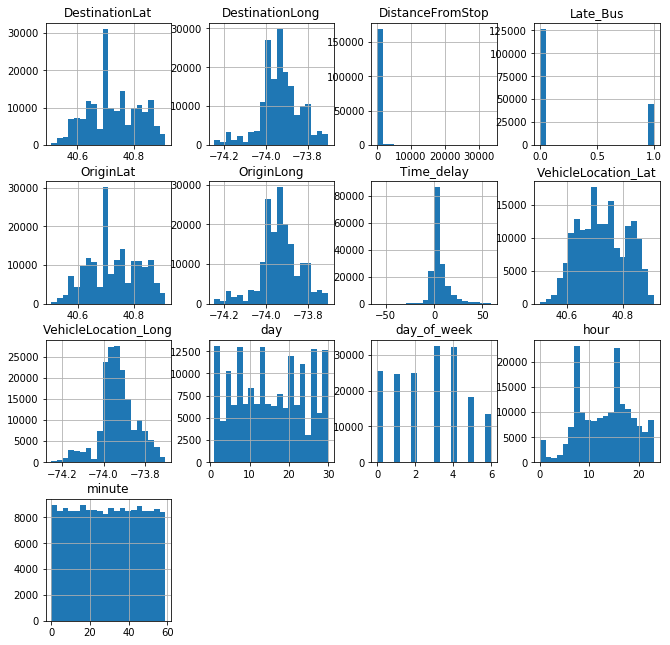

In [30]:
mta.hist(figsize=(11,11),bins=20)
plt.show()

From the histograms of our continuous features we can see that we have a very unbalanced target, which would be expected. There should definetly be more on-time buses that late ones. From here I want to look at the continuous variables for against the target.
 

In [31]:
# Test of the mean distance between stops of late and on-time buses
Late_Bus_dist = mta[mta.Late_Bus==1] 
On_Time_Bus_dist = mta[mta.Late_Bus==0] 
print(stats.ttest_ind(Late_Bus_dist.DistanceFromStop,On_Time_Bus_dist.DistanceFromStop),'\n')

# calculate correlation distance from stop and late buses
print('Correlation of distance from stops and late buses \n',mta.DistanceFromStop.corr(mta.Late_Bus))
print()
print(stats.ttest_ind(Late_Bus_dist.Time_delay,On_Time_Bus_dist.Time_delay),'\n')

 

Ttest_indResult(statistic=7.869970433057999, pvalue=3.567719827090452e-15) 

Correlation of distance from stops and late buses 
 0.018973870829949994

Ttest_indResult(statistic=486.5687532774816, pvalue=0.0) 



There is a statistically significant difference in the average distance from stop of Late buses and on-time buses. There is also a positive correlation between distance from stop and late buses.

In [32]:
mta[['Time_delay','DistanceFromStop']].describe()

,Time_delay,DistanceFromStop
count,171982.000000,171982.000000
mean,5.344042,245.051738
std,9.176854,1027.517800
min,-59.000000,0.000000
25%,0.000000,32.000000
50%,3.000000,104.000000
75%,8.000000,212.000000
max,59.000000,33604.000000


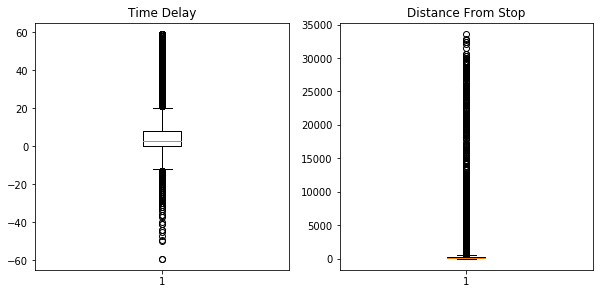

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.boxplot(mta.Time_delay)
plt.title('Time Delay')
plt.subplot(222)
plt.title('Distance From Stop')
plt.boxplot(mta.DistanceFromStop) 
plt.show()

Nothing will be done to correct the outliers in the Time Delay variable. We used this to create out target variable and it will not be used in any models. As far a the distance from stop variable we can look at winzorizing to minimize the outliers.

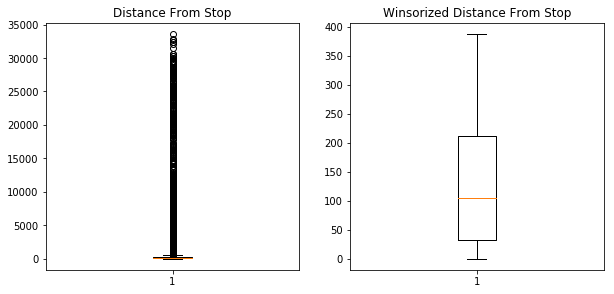

In [34]:
winsor_dist = winsorize(mta["DistanceFromStop"], (0, .1)) # one way wizorization of distance from stop 
#                                                           variable with limit set at the 90th percentile

plt.figure(figsize=(10,10))
plt.title('Distance From Stop') 
plt.subplot(221)
plt.title('Distance From Stop')
plt.boxplot(mta.DistanceFromStop) 


plt.subplot(222)
plt.title('Winsorized Distance From Stop')
plt.boxplot(winsor_dist)
plt.show()

In [35]:
# create a feature for winsorization of the distance from stops
mta['winsor_dist'] = winsor_dist 

In [36]:
mta.sample(frac=.1)[:10]

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week,winsor_dist
34488,2017-06-07 00:13:11,0,Q24,PATCHEN AV/LAFAYETTE AV,40.692478,-73.927902,JAMAICA 168 ST via ATLANTIC,40.704441,-73.792610,NYCT_4853,40.678216,-73.903494,JAMAICA AV/GEORGIA AV,493.0,2017-06-07 00:14:51,2017-06-07 00:13:00,1.0,0,7,0,13,Wednesday,2,388.0
84691,2017-06-15 12:47:07,0,S74,BRICKTOWN SHOPPING/CENTER,40.530102,-74.226295,ST GEORGE FERRY,40.643585,-74.072609,NYCT_8159,40.579366,-74.114619,RICHMOND RD/BANCROFT AV,5.0,2017-06-15 12:47:40,2017-06-15 12:46:42,0.0,0,15,12,46,Thursday,3,5.0
127937,2017-06-23 07:50:31,1,Q28,23 AV/BELL BL,40.782291,-73.777061,FLUSHING MAIN ST STA,40.760937,-73.827286,NYCT_4198,40.760701,-73.828395,39 AV /138 ST,97.0,2017-06-23 07:51:25,2017-06-23 07:50:00,1.0,0,23,7,50,Friday,4,97.0
74588,2017-06-13 21:04:36,0,M57,W 72 ST/BROADWAY,40.779034,-73.982414,EAST SIDE YORK - 60 ST XTOWN,40.759518,-73.959892,NYCT_3908,40.758338,-73.962903,1 AV/E 57 ST,65.0,2017-06-13 21:04:58,2017-06-13 21:01:35,3.0,0,13,21,1,Tuesday,1,65.0
30538,2017-06-06 11:33:18,1,Q58,41 RD/MAIN ST,40.757389,-73.829292,RIDGEWOOD TERM,40.699699,-73.910767,NYCT_7257,40.717494,-73.901963,FRESH POND RD/60 AV,90.0,2017-06-06 11:33:39,2017-06-06 11:35:43,-2.0,0,6,11,35,Tuesday,1,90.0
61110,2017-06-11 18:11:00,1,M60-SBS,LGA/TERMINAL D,40.768387,-73.862534,WEST SIDE BWAY - 106 ST,40.801422,-73.968239,NYCT_5863,40.813370,-73.956266,AMSTERDAM AV/W 125 ST,70.0,2017-06-11 18:11:23,2017-06-11 17:16:36,54.0,1,11,17,16,Sunday,6,70.0
142150,2017-06-26 07:45:04,0,B14,EASTERN PY/UTICA AV,40.668537,-73.931236,SPRING CREEK STANLEY AV POSTAL FAC,40.664642,-73.863068,NYCT_7094,40.673430,-73.867461,SUTTER AV/LINCOLN AV,94.0,2017-06-26 07:45:32,2017-06-26 07:51:09,-5.0,0,26,7,51,Monday,0,94.0
153755,2017-06-28 00:08:24,0,M102,ASTOR PL/3 AV,40.729568,-73.990051,HARLEM 147 ST via 3 AV,40.821198,-73.936119,NYCT_6071,40.745078,-73.978592,3 AV/E 33 ST,16.0,2017-06-28 00:08:55,2017-06-27 23:49:31,19.0,1,27,23,49,Tuesday,1,16.0
74314,2017-06-13 19:55:12,1,Bx13,RIVER AV/E 150 ST,40.820633,-73.929497,WASHINGTON HTS GW BRIDGE,40.849113,-73.937752,NYCT_8387,40.848970,-73.937234,W 179 ST/BROADWAY,45.0,2017-06-13 19:55:31,2017-06-13 19:54:00,1.0,0,13,19,54,Tuesday,1,45.0
106191,2017-06-19 15:44:19,1,B41,CADMAN PLAZA WEST/JOHNSON ST,40.695534,-73.990829,LTD KINGS PLAZA via FLATBUSH,40.609211,-73.921516,NYCT_5066,40.639748,-73.954891,FLATBUSH AV/FOSTER AV,204.0,2017-06-19 15:45:24,2017-06-19 15:36:56,8.0,1,19,15,36,Monday,0,204.0


# Categorical Variables

In [37]:
mta[['PublishedLineName', 'OriginName','DestinationName','VehicleRef','NextStopPointName']].describe()

,PublishedLineName,OriginName,DestinationName,VehicleRef,NextStopPointName
count,171982,171982,171982,171982,171982
unique,236,582,610,4460,8877
top,B6,E 126 ST/2 AV,WASHINGTON HTS GW BRIDGE,NYCT_4624,BAY ST/NICK LAPORTE PL
freq,3299,2923,2395,94,340


# Late Buses and Time Delays by hour


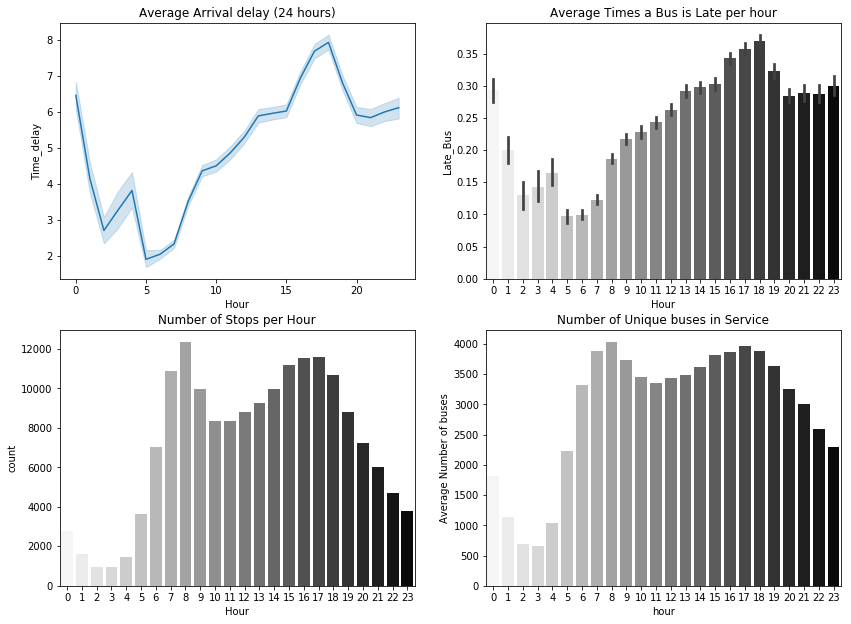

In [38]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.hour, 
             y=mta.Time_delay, data=mta,)
plt.title('Average Arrival delay (24 hours)') 
plt.xlabel('Hour')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.hour,mta[mta.DistanceFromStop<500].Late_Bus,palette= "gist_gray_r")
plt.title('Average Times a Bus is Late per hour')
plt.xlabel('Hour')

plt.subplot(323)
sns.countplot(mta.ScheduledArrivalTime.dt.hour, palette= "gist_gray_r")
plt.title('Number of Stops per Hour') 
plt.xlabel('Hour')

plt.subplot(324)
hour_df = pd.DataFrame(mta.groupby('hour').VehicleRef.unique())
hour_df = pd.DataFrame(hour_df.VehicleRef.apply(lambda x : len(x)))
plt.title('Number of Unique buses in Service')
plt.xlabel('Hour')
plt.ylabel('buses in Service')
hour_df['hour'] = hour_df.index
hour_df.index = range(len(hour_df))
sns.barplot(hour_df.hour, hour_df.VehicleRef, palette= "gist_gray_r")
plt.ylabel('Average Number of buses')

plt.show()

After 6a.m. then average number of late buses steadily increases and peaks at 6p.m. It then flattens and falls between the hours of 1a.m. and 6a.m. This could be because there is less traffic at this time. 

In [39]:
index = mta[(mta.ScheduledArrivalTime.dt.hour>=8) & (mta.ScheduledArrivalTime.dt.hour<=19)].index  
mta['increased_Late'] = 0
mta.loc[index,'increased_Late'] = 1


In [40]:
mta.increased_Late.value_counts()

1    120915
0     51067
Name: increased_Late, dtype: int64

Here I am going to bin hours in to groups to form a feature that represents afternoon evening and night to caprture the differences in late buses during those times. 

In [41]:
# create time of day feature
bins=[-1, 5, 11, 16, 20, 23]
bin_names = ['night','morning','afternoon','evening','Night']
mta['time_of_day'] = pd.cut(mta.ScheduledArrivalTime.dt.hour, bins,labels=bin_names)
mta['time_of_day'] = mta['time_of_day'].str.lower().astype('category')

In [42]:
(mta.groupby(mta.time_of_day).Late_Bus.mean().sort_index(ascending=False)*100).astype(str)+" %"

time_of_day
night        23.938938360124897 %
morning      18.251778968637442 %
evening      34.281757851282855 %
afternoon     30.30165971839849 %
Name: Late_Bus, dtype: object

Afternoon and evening look to have the greatest average of late buses. Before looking I would have expected morning and evening to have the worse of the problem because of traffic at those times. Lets do a ttest to confirm that there is significant differences in the average number of late buses between each time of day.

In [43]:
# t-test between the means of the percentage of late buses of the hours in the day
tod_pvalues = {}
for i in range(len(mta.time_of_day.unique())):
        for j in range(i+1,4):
            print(mta.time_of_day.unique()[i],' vs ',mta.time_of_day
                  .unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.time_of_day==mta.time_of_day.unique()[i]]['Late_Bus'], 
                mta[mta.time_of_day==mta.time_of_day.unique()[j]]['Late_Bus']))           

night  vs  morning
Ttest_indResult(statistic=19.00889082229515, pvalue=2.136968194419023e-80)
night  vs  afternoon
Ttest_indResult(statistic=-18.583812273183533, pvalue=6.413705965363733e-77)
night  vs  evening
Ttest_indResult(statistic=-28.209624725402243, pvalue=5.1712516060528955e-174)
morning  vs  afternoon
Ttest_indResult(statistic=-46.74507788922478, pvalue=0.0)
morning  vs  evening
Ttest_indResult(statistic=-57.18821681162569, pvalue=0.0)
afternoon  vs  evening
Ttest_indResult(statistic=-12.618618392964219, pvalue=1.7915378013284652e-36)


 There looks to be significant diffences between each time of day.

### What percentage of buses are late per hour?


Here is a numerical representation of the graphs above.

In [44]:
(mta.groupby(mta.ScheduledArrivalTime.dt.hour).Late_Bus.mean().sort_index(ascending=False)*100).astype(str)+" %"

ScheduledArrivalTime
23    29.976209357652657 %
22     28.85763000852515 %
21    28.756004638065264 %
20    28.446601941747574 %
19     32.71506599908967 %
18     37.24170172978027 %
17    36.369916242120716 %
16     34.34282253179891 %
15    30.399071511472194 %
14    29.870909636745722 %
13    29.231763818554036 %
12    26.496598639455783 %
11     24.40225880091313 %
10     22.69359464627151 %
9     21.458667736757626 %
8      18.52512155591572 %
7     12.466721747911503 %
6      9.611277231952158 %
5      9.563066776586975 %
4      16.15956727518594 %
3     14.101184068891282 %
2     12.812499999999998 %
1     19.889162561576352 %
0     29.378127233738383 %
Name: Late_Bus, dtype: object

# Late buses and Time Delays by day of the Week

In [45]:
print('Description of Late buses Delays by Weekday')
weekday_order={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
Late_bus_mean = mta[mta.Time_delay>=0].groupby(mta.ScheduledArrivalTime.dt.weekday).Late_Bus.describe()
Late_bus_mean.index = weekday_order.values()
Late_bus_mean

Description of Late buses Delays by Weekday


,count,mean,std,min,25%,50%,75%,max
Monday,20527.0,0.255956,0.436408,0.0,0.0,0.0,1.0,1.0
Tuesday,20585.0,0.295895,0.456455,0.0,0.0,0.0,1.0,1.0
Wednesday,21248.0,0.325489,0.468568,0.0,0.0,0.0,1.0,1.0
Thursday,27062.0,0.316569,0.465146,0.0,0.0,0.0,1.0,1.0
Friday,27090.0,0.329716,0.470119,0.0,0.0,0.0,1.0,1.0
Saturday,15871.0,0.345095,0.475414,0.0,0.0,0.0,1.0,1.0
Sunday,11835.0,0.328771,0.469786,0.0,0.0,0.0,1.0,1.0


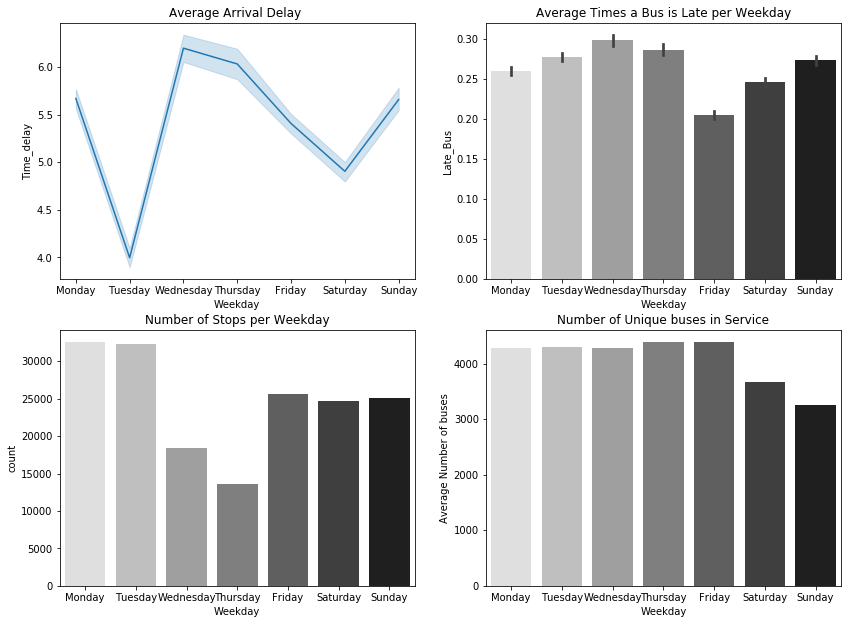

In [46]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.day_name(), 
             y=mta.Time_delay, data=mta)
plt.xticks(range(0,7), weekday_order.values())
plt.title('Average Arrival Delay ') 
plt.xlabel('Weekday')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.day_name(),mta[mta.DistanceFromStop<500].Late_Bus, palette= "gist_gray_r")
plt.title('Average Times a Bus is Late per Weekday')
plt.xticks(range(0,7), weekday_order.values())
plt.xlabel('Weekday')

plt.subplot(323)
sns.countplot(mta.ScheduledArrivalTime.dt.day_name(), palette= "gist_gray_r")
plt.xticks(range(0,7), weekday_order.values())
plt.title('Number of Stops per Weekday') 
plt.xlabel('Weekday')

plt.subplot(324)
day_df = pd.DataFrame(mta.groupby('day_of_week').VehicleRef.unique())
day_df = pd.DataFrame(day_df.VehicleRef.apply(lambda x : len(x)))
plt.title('Number of Unique buses in Service')
plt.xlabel('Weekday')
plt.ylabel('buses in Service')
day_df['Weekday'] = day_df.index
day_df.index = range(len(day_df))
sns.barplot(day_df.Weekday, day_df.VehicleRef,palette= "gist_gray_r")
plt.ylabel('Average Number of buses')
plt.xticks(range(0,7),weekday_order.values())
plt.show()

In [47]:
#ttest between the means of the percentage of late buses of the days of the week
pvales = {}
for i in range(len(mta.ScheduledArrivalTime.dt.weekday.unique())):
        for j in range(i+1,7):
            print(mta.ScheduledArrivalTime.dt.day_name().unique()[i],' vs ',mta.ScheduledArrivalTime.dt.day_name().unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[i]]['Late_Bus'], 
                mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[j]]['Late_Bus']))
            pvales.update({(mta.ScheduledArrivalTime.dt.day_name().unique()[i],' vs ',mta.ScheduledArrivalTime.dt.day_name().unique()[j]):
                          stats.ttest_ind(
                          mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[i]]['Late_Bus'], 
                          mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[j]]['Late_Bus'])[1]})

Thursday  vs  Friday
Ttest_indResult(statistic=-3.874699610921449, pvalue=0.0001068612521110952)
Thursday  vs  Saturday
Ttest_indResult(statistic=-8.44252567407665, pvalue=3.1861069752606367e-17)
Thursday  vs  Sunday
Ttest_indResult(statistic=-5.1742028676756, pvalue=2.2984257981419786e-07)
Thursday  vs  Monday
Ttest_indResult(statistic=16.24775824958174, pvalue=3.1312035338786083e-59)
Thursday  vs  Tuesday
Ttest_indResult(statistic=4.332561679644271, pvalue=1.4763533149085799e-05)
Thursday  vs  Wednesday
Ttest_indResult(statistic=-3.5254173327051785, pvalue=0.0004231443955736152)
Friday  vs  Saturday
Ttest_indResult(statistic=-5.105234629258896, pvalue=3.315776132304915e-07)
Friday  vs  Sunday
Ttest_indResult(statistic=-2.1687617303009112, pvalue=0.03010590212819787)
Friday  vs  Monday
Ttest_indResult(statistic=19.830270702355577, pvalue=3.1848433195179643e-87)
Friday  vs  Tuesday
Ttest_indResult(statistic=7.910482093475379, pvalue=2.6098200432462915e-15)
Friday  vs  Wednesday
Ttest_i

In [48]:
# find all comparisons with pvalues > .05
non_significant = [i for i in pvales if pvales.get(i)>.05]
non_significant

[('Friday', ' vs ', 'Wednesday')]

There is no statistcal significance in the average number of late buses between the above days of the week.
Wednesday and Thursday have the greatest average number of late buses. I will make and indicator feature to mark these days. 

In [49]:
# mark Wed and Thurs. as peak late buses
mta['is_midweek'] = 0
mta.loc[list(np.where(mta[(mta.ScheduledArrivalTime.dt.weekday==2)|(mta.ScheduledArrivalTime.dt.weekday==3)])[0]),'is_midweek'] = 1

In [50]:
mta.is_midweek.value_counts()

0    114415
1     57567
Name: is_midweek, dtype: int64

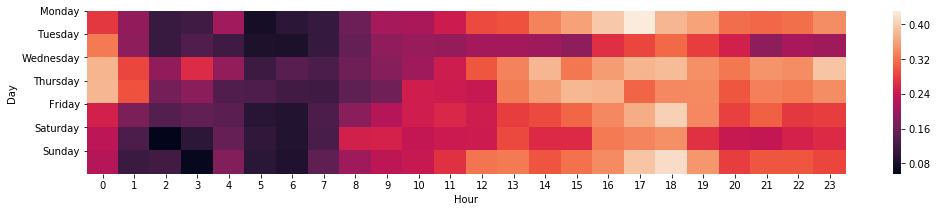

In [51]:
plt.figure(figsize=(17,3))
heat_weekdayhour = mta.pivot_table(index=mta.ScheduledArrivalTime.dt.day_name(), columns=mta.ScheduledArrivalTime.dt.hour, values="Late_Bus")
sns.heatmap(heat_weekdayhour,)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.yticks(np.arange(7),weekday_order.values())
plt.show() 

The heatmap above shows the average late buses of the days of week by hour. There doesnt seem to be any significant difference between the hours that we normally associate with rush hour. it seems that there is just a steady increase of late buses from about 9:30 am up to midnight and then a lull between those times. 

# Late buses and Time Delays by day of the Month

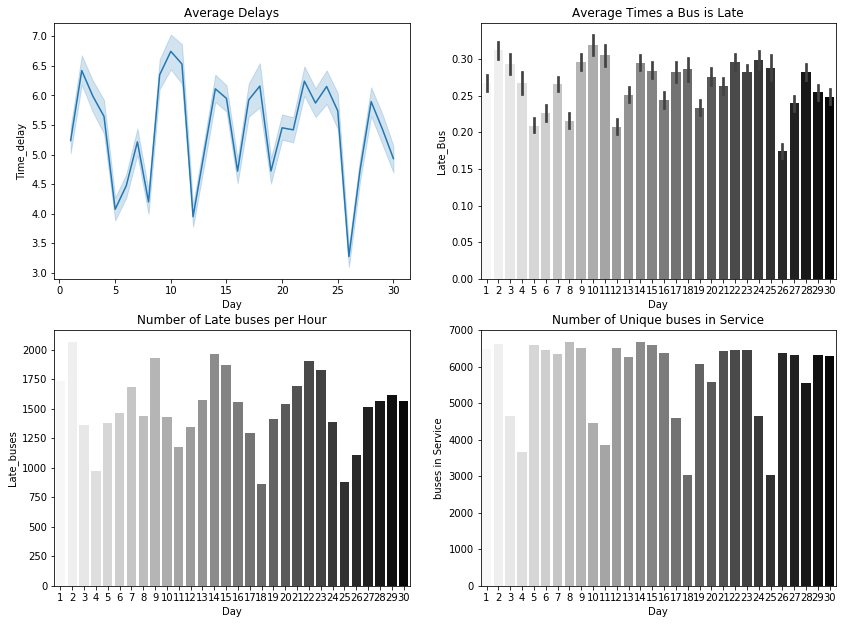

In [52]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.day , 
             y=mta.Time_delay, data=mta,)
plt.xlabel('Day')
plt.title('Average Delays')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.day,mta.Late_Bus,palette= "gist_gray_r")
plt.xlabel('Day')

plt.title('Average Times a Bus is Late')
 
plt.subplot(323)
sns.countplot(mta[mta.Late_Bus==1].ScheduledArrivalTime.dt.day , palette= "gist_gray_r")
plt.title('Number of Late buses per Hour')
plt.xlabel('Day')

plt.ylabel('Late_buses')

plt.subplot(324)
#daydf = pd.DataFrame(mta.groupby('day').VehicleRef.unique())
#daydf = pd.DataFrame(daydf.VehicleRef.apply(lambda x : len(x)))
#daydf['day_of_month'] = daydf.index
#daydf.index = range(len(daydf))
#sns.barplot(daydf.day_of_month, daydf.VehicleRef,palette= "gist_gray_r")
sns.countplot(mta.ScheduledArrivalTime.dt.day, palette= "gist_gray_r")
plt.title('Number of Unique buses in Service')
plt.xlabel('Day')
plt.ylabel('buses in Service')

plt.show()

The days of the month seem to follow a weekly pattern. With the weekends having the least amount of late buses. The weekends also have fewer buses in service. The number of late buses doesn't seem to be affected by a larger number of buses in service.

# Inbound and Outbound Late buses and Delays

Let's see if there is any difference between the number of late buses of inbound vs outbound buses.

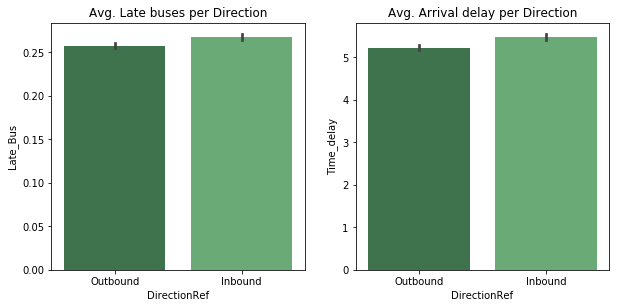

In [55]:
inbound_df = mta[mta.DirectionRef==1]
outbound_df = mta[mta.DirectionRef==0] 
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.barplot(y=mta.Late_Bus,x=mta.DirectionRef,palette="Greens_d",orient='vertical',) 
plt.title('Avg. Late buses per Direction')
plt.xticks(range(0,2), ['Outbound','Inbound'])

plt.subplot(222)
sns.barplot(y=mta.Time_delay,x=mta.DirectionRef,palette="Greens_d",orient='vertical',) 
plt.title('Avg. Arrival delay per Direction')
plt.xticks(range(0,2), ['Outbound','Inbound'])
plt.show()

The average number of late buses is higher with the inbound buses as well as the average arrival delay.

In [56]:

# Test of the average number of late buses of inbound and outbound buses 
print(stats.ttest_ind(inbound_df.Late_Bus, outbound_df.Late_Bus),'\n')


Ttest_indResult(statistic=4.790982045336751, pvalue=1.661050328559205e-06) 



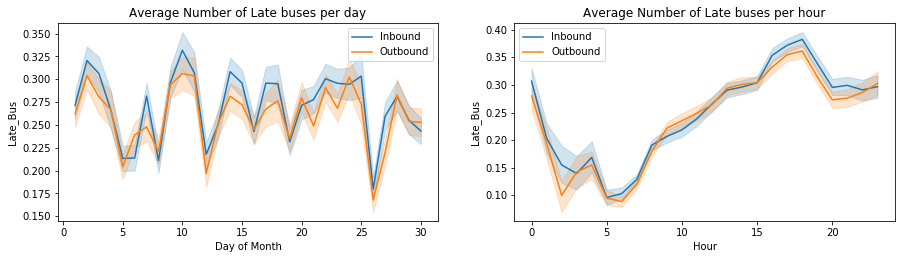

In [58]:
plt.figure(figsize=(15,8))
plt.subplot(221)
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.day.sort_values(), inbound_df.Late_Bus, label='Inbound') 
sns.lineplot(outbound_df.ScheduledArrivalTime.dt.day.sort_values(), outbound_df.Late_Bus, label='Outbound')
plt.title('Average Number of Late buses per day')
plt.xticks=(np.arange(0,30,.5))
plt.xlabel('Day of Month')
plt.subplot(222)
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.Late_Bus, label='Inbound') 
sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.Late_Bus, label='Outbound')
plt.title('Average Number of Late buses per hour')
plt.xlabel('Hour')
plt.xticks=(np.arange(0,30,.5))
plt.show() 

The inbound and outbound buses show the same pattern over the days of the month. With respect to hour there are more late inbound buses thoughout most of the day.

## Distance from stop vs Late buses 

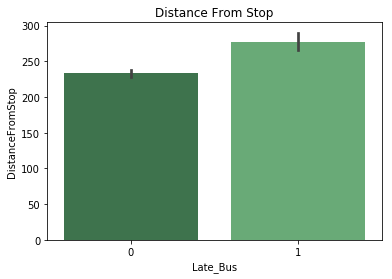

In [59]:
sns.barplot(x='Late_Bus',y='DistanceFromStop', data=mta, palette="Greens_d")
plt.title('Distance From Stop')
#plt.xticks(list(range(0,2)), ['On-Time','Late'])
plt.show()

In [60]:
print('Average distance from stop of on-time and late buses')
mta.groupby('Late_Bus').mean()[['DistanceFromStop']]

Average distance from stop of on-time and late buses


,DistanceFromStop
Late_Bus,
0,233.423471
1,277.738588


In [61]:
onTime_df = mta[mta.Late_Bus==1]
Late_df = mta[mta.Late_Bus==0] 
print('Ttest of average distance between stops of late and on-time buses:')
print()
print(stats.ttest_ind(onTime_df.DistanceFromStop, Late_df.DistanceFromStop),'\n')

Ttest of average distance between stops of late and on-time buses:

Ttest_indResult(statistic=7.869970433057999, pvalue=3.567719827090452e-15) 



The ttest shows a significant difference between the average distance from a stop and late buses.

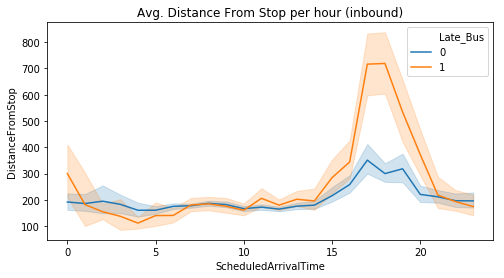

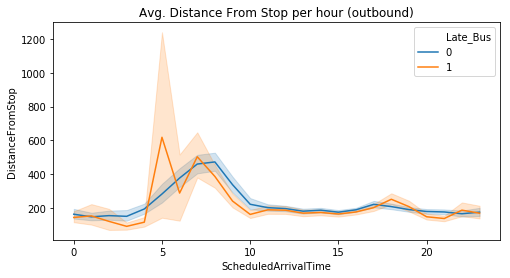

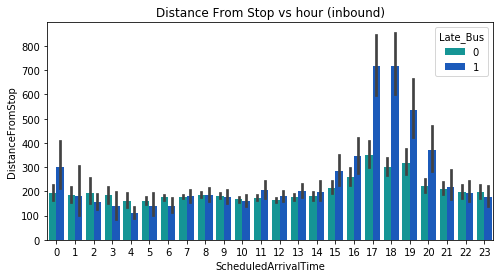

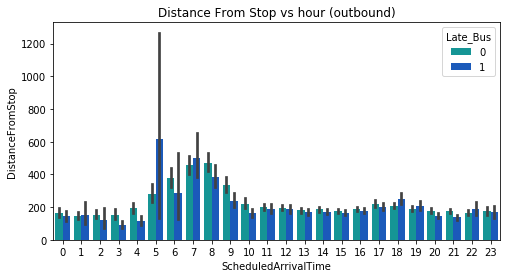

In [62]:
plt.figure(figsize=(8,4))
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop, hue=inbound_df.Late_Bus) 
plt.title('Avg. Distance From Stop per hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))

sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop, hue=outbound_df.Late_Bus)
plt.title('Avg. Distance From Stop per hour (outbound)')
#plt.xticks=(np.arange(0,30,.5))
plt.show() 
plt.figure(figsize=(8,4))
sns.barplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop,hue=inbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop,hue=outbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (outbound)')
#sns.lineplot(mta.ScheduledArrivalTime.dt.hour.sort_values(), mta.DistanceFromStop, hue=mta.Late_Bus)

plt.show() 

There seems to be a pattern as the day goes on. The distacnce from stops increases for the inbound buses between 3pm and 9pm and for the outbound buses between 5am and 9am. The distance between stops for late buses is father than for the inbound buses than for the outbound. For the outbound buses it seems that distance between stops is greater for the on-time buses. This coincides with New Yorks rush hour. Since the buses are recorded approximately every ten minutes the buses are farther away from their stops for a longer amount of time because of traffic. This could possibly be why this pattern is showing. It doesn't explain the reason the distance between stops is greater for on time buses on the outbound side and the opposite for the inbound. This could be that there are more buses running at that time or that the buses are moving slower but the schedule accounts for those delays making the buses on time. 

I'm goding to create an indicator feature to mark this pattern.

In [63]:
# create rush our indicator feature
mta['rush_hour'] = np.where(np.logical_and(mta.hour>=5, mta.hour<=9) | np.logical_and(mta.hour>=15, mta.hour<=21),1,0)

## Which boroughs have the farthest distance from stop?


The route label prefixes signify the boroughs of New York that the operate in with the exception of routes that begin with "X". The "X" routes are express routes that a operate in all five boroghs and have large distances between stops. Here I will create a feature that groups the published line name(route) in to their areas of operation to condense dimentionality and for analysis.

In [64]:
# create new feature based on the route names and areas of operation based on prefix
def boroughs():
    mta['boroughs'] = '0'
    mta.loc[list(np.where((mta.PublishedLineName.str.contains('x')==False) & (mta.PublishedLineName.str.startswith('B')==True))[0]),'boroughs'] = 'Brooklyn'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('Bx')==True)[0]),'boroughs'] = 'Bronx'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('Q')==True)[0]),'boroughs'] = 'Queens'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('S')==True)[0]),'boroughs'] = 'Staten Island'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('M')==True)[0]),'boroughs'] = 'Manhattan'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('X')==True)[0]),'boroughs'] = 'X'
    mta['boroughs'] = mta.boroughs.astype('category')
boroughs()


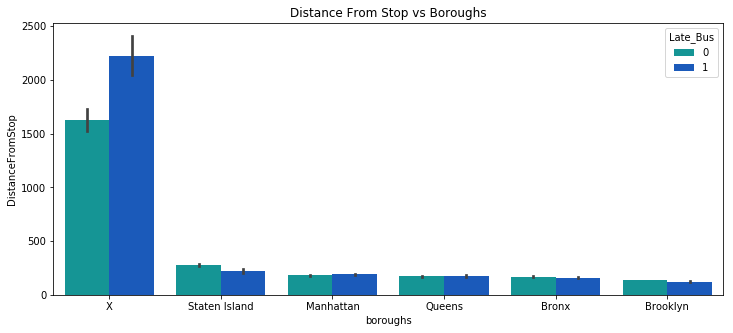

In [65]:
plt.figure(figsize=(12,5)) 
order = mta.groupby('boroughs').DistanceFromStop.mean().sort_values(ascending=False).index
sns.barplot(x='boroughs',y='DistanceFromStop' ,data=mta, hue=mta.Late_Bus,order=order,palette='winter_r')
plt.title('Distance From Stop vs Boroughs')
plt.show()

The "X" routes have the largest average distance from stops. It look like those routes are also resposible for the distance from stops for late buses being greater than the distance from stops for the on-time buses. Let's see what happens when we exclude the "X" routes.

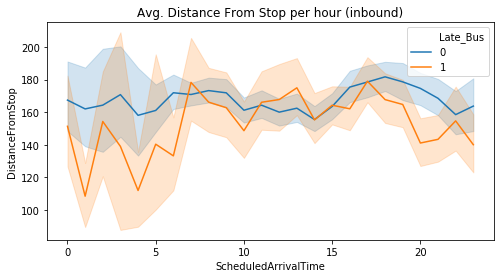

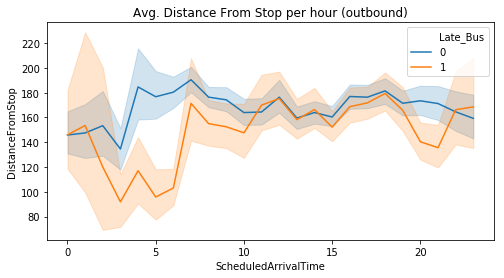

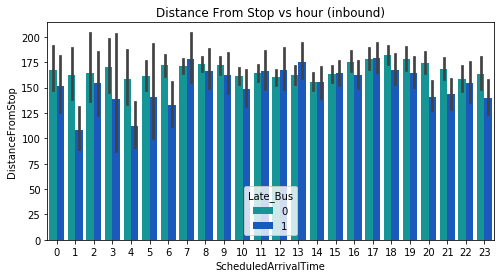

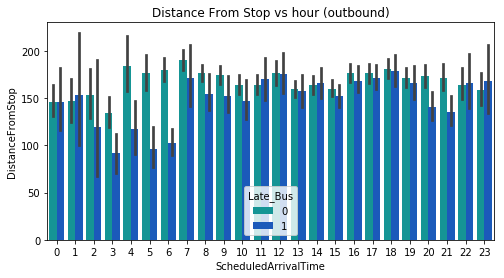

In [66]:
no_x_df = mta[mta.boroughs!='X']
inbound_df = no_x_df[no_x_df.DirectionRef==1]
outbound_df = no_x_df[no_x_df.DirectionRef==0] 

plt.figure(figsize=(8,4))
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop, hue=inbound_df.Late_Bus) 
plt.title('Avg. Distance From Stop per hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))

sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop, hue=outbound_df.Late_Bus)
plt.title('Avg. Distance From Stop per hour (outbound)')
#plt.xticks=(np.arange(0,30,.5))
plt.show() 
plt.figure(figsize=(8,4))
sns.barplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop,hue=inbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop,hue=outbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (outbound)')
#sns.lineplot(mta.ScheduledArrivalTime.dt.hour.sort_values(), mta.DistanceFromStop, hue=mta.Late_Bus)

plt.show() 

Without the "X" routes the pattern pretty much disappears. This is something to be aware of when modeling because we don't want the algorithm to always focus in on the "X" routes.

In [67]:
#ttest between the means of the percentage of late buses of the days of the week
pvales = {}
for i in range(len(mta.boroughs.unique())):
        for j in range(i+1,6):
            print(mta.boroughs.unique()[i],' vs ',mta.boroughs.unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.boroughs==mta.boroughs.unique()[i]]['Late_Bus'], 
                mta[mta.boroughs==mta.boroughs.unique()[j]]['Late_Bus']))
            pvales.update({(mta.boroughs.unique()[i],' vs ',mta.boroughs.unique()[j]):
                          stats.ttest_ind(
                          mta[mta.boroughs==mta.boroughs.unique()[i]]['Late_Bus'], 
                          mta[mta.boroughs==mta.boroughs.unique()[j]]['Late_Bus'])[1]})

Manhattan  vs  Brooklyn
Ttest_indResult(statistic=7.397726815509001, pvalue=1.3978586822200188e-13)
Manhattan  vs  X
Ttest_indResult(statistic=-3.2957982418820144, pvalue=0.0009822314757460442)
Manhattan  vs  Queens
Ttest_indResult(statistic=18.28209456712291, pvalue=1.7645508928062523e-74)
Manhattan  vs  Bronx
Ttest_indResult(statistic=17.287575880836396, pvalue=8.039983664568708e-67)
Manhattan  vs  Staten Island
Ttest_indResult(statistic=19.13591801031647, pvalue=2.6653098257053266e-81)
Brooklyn  vs  X
Ttest_indResult(statistic=-7.8023183134589615, pvalue=6.175442628223829e-15)
Brooklyn  vs  Queens
Ttest_indResult(statistic=12.757972287658887, pvalue=3.05049447126417e-37)
Brooklyn  vs  Bronx
Ttest_indResult(statistic=11.484193745937077, pvalue=1.665720825203982e-30)
Brooklyn  vs  Staten Island
Ttest_indResult(statistic=15.224669341466809, pvalue=3.006962424779198e-52)
X  vs  Queens
Ttest_indResult(statistic=15.164784448740084, pvalue=8.49716149148302e-52)
X  vs  Bronx
Ttest_indResult

In [68]:
# find all comparisons with pvalues > .05
non_significant = [i for i in pvales if pvales.get(i)>.05]
non_significant

[('Queens', ' vs ', 'Bronx')]

## Compare boroughs to late buses

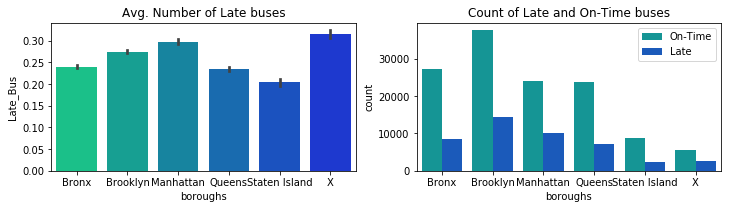

In [69]:
plt.figure(figsize=(12,6)) 
plt.subplot(221)
sns.barplot(x='boroughs',y='Late_Bus' ,data=mta,  palette='winter_r' )
plt.title('Avg. Number of Late buses')

plt.subplot(222)
sns.countplot(x='boroughs',hue='Late_Bus' ,data=mta,  palette='winter_r' )
plt.legend(['On-Time','Late'])
plt.title('Count of Late and On-Time buses')
plt.show()

In [70]:
# chi-square test to test significance of group size
borough_count_table = pd.crosstab(mta.Late_Bus,mta.boroughs)
print('Chi-square Test Results significance of group size of boroughs')
print(stats.chisquare(borough_count_table, axis=None))


Chi-square Test Results significance of group size of boroughs
Power_divergenceResult(statistic=97042.84073914713, pvalue=0.0)


In [71]:
mta.groupby('boroughs').Late_Bus.agg(['mean','count'])

,mean,count
boroughs,,
Bronx,0.240065,35682
Brooklyn,0.274687,52052
Manhattan,0.297884,34265
Queens,0.234608,31039
Staten Island,0.204192,10877
X,0.316598,8067


Although the "X" routes are represented the least in the dataset they have the highest agverage of late buses. 

#  Geospacial features

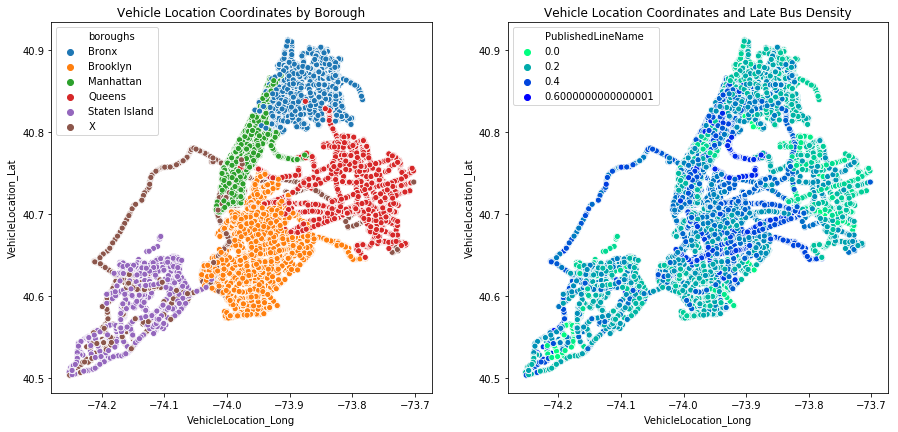

In [72]:
mean_late = mta.PublishedLineName.map(dict(mta.groupby('PublishedLineName').Late_Bus.mean().sort_values(ascending=False)))
plt.figure(figsize=(15,15))
 
plt.subplot(222)
sns.scatterplot(mta.VehicleLocation_Long,mta.VehicleLocation_Lat,hue=mean_late, palette='winter_r')
plt.title('Vehicle Location Coordinates and Late Bus Density')
 
plt.subplot(221)
sns.scatterplot(mta.VehicleLocation_Long,mta.VehicleLocation_Lat,hue=mta.boroughs)
plt.title('Vehicle Location Coordinates by Borough')
plt.show()

Above are scatterplots of the lattitudes and longitudes of the vehicle locations. You can see the shape of New York made from the lats and longs. There doesn't seem to be any points that fall far outside of the area that we are concerned with. The left plot shows the buses grouped by their respective areas of operation and the left highlights the areas where the average number of late buses is the greatest. This may indicate that vehicle location may be a good predictor of whether a bus is going to be late or not. Since there is no meaningful relationship between the raw lattitude and longitude I will create a couple of features to cut down on the dimentionality and well as creating something useful that a model such a Random Forest could use. 

In [73]:
# function to convert lat and long to zip code

def geo_to_zip(lat,long,zip_type):
    from uszipcode import SearchEngine
    from datetime import datetime
    startTime = datetime.now()
     
    search = SearchEngine(simple_zipcode=True)
    mta['col'] = mta[lat].astype(str)+' '+mta[long].astype(str)
    mta[zip_type] = mta['col'].apply(lambda x: search.by_coordinates(float(x.split()[0]),
                                    float(x.split()[1]), radius=10, returns=5)[0].values()[0])
   
    print(datetime.now() - startTime)
    print('done')
    mta.drop('col',1,inplace=True)
#geo_to_zip('OriginLat', 'OriginLong','Orig_zip')
#geo_to_zip('DestinationLat','DestinationLong','Dest_zip')
#geo_to_zip('VehicleLocation_Lat','VehicleLocation_Long','VL_Zip')

In [74]:

# fucntion to convert to compute distance between two points and create a columns of those distances
def distance_between_points(lat1,long1,lat2,long2,to_from):
    import mpu
    from datetime import datetime
    startTime = datetime.now()
    mta['point1'] =mta[lat1].astype(str)+" "+mta[long1].astype(str)
    mta['point2'] = mta[lat2].astype(str)+" "+mta[long2].astype(str)

    mta[to_from] = mta['point1']+" "+mta['point2']
    mta[to_from] = mta[to_from].apply(lambda x : mpu.haversine_distance((float(x.split()[0]), float(x.split()[1])),
                                                                              (float(x.split()[2]), float(x.split()[3]))))
    mta.drop('point1',1,inplace=True)
    mta.drop('point2',1,inplace=True)
    print(datetime.now() - startTime)
    print('done')
    return;


distance_between_points('VehicleLocation_Lat','VehicleLocation_Long','DestinationLat','DestinationLong','VL_to_Dest')
distance_between_points('VehicleLocation_Lat','VehicleLocation_Long','OriginLat', 'OriginLong','VL_to_Origin')
distance_between_points('DestinationLat','DestinationLong','OriginLat', 'OriginLong','Dest_to_Origin') 

0:00:01.403581
done
0:00:01.409962
done
0:00:01.496436
done


In [75]:
# winsorizing the distances to reduce outliers
mta["winVL_to_Dest"]  = winsorize(mta["VL_to_Dest"], (0, .1)) 
mta["winVL_to_Origin"] =winsor_distVL= winsorize(mta["VL_to_Origin"], (0, .1)) 
mta["winDest_to_Origin"] =winsor_distOD= winsorize(mta["Dest_to_Origin"], (0, .1))

In [76]:
#create geohash features from lat and long
import pygeohash as gh
mta['VL_geohash']=mta.apply(lambda x: gh.encode(x.VehicleLocation_Lat, x.VehicleLocation_Long, precision=5), axis=1).astype('category')
mta['O_geohash']=mta.apply(lambda x: gh.encode(x.OriginLat, x.OriginLong, precision=5), axis=1).astype('category')
mta['D_geohash']=mta.apply(lambda x: gh.encode(x.DestinationLat, x.DestinationLong, precision=5), axis=1).astype('category')

In [77]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week,winsor_dist,increased_Late,time_of_day,is_midweek,rush_hour,boroughs,VL_to_Dest,VL_to_Origin,Dest_to_Origin,winVL_to_Dest,winVL_to_Origin,winDest_to_Origin,VL_geohash,O_geohash,D_geohash
0,2017-06-01 00:13:34,1,M15,E 126 ST/2 AV,40.803230,-73.932449,SOUTH FERRY via 2 AV,40.701611,-74.012230,NYCT_5643,40.701616,-74.011917,SOUTH ST/WHITEHALL ST,25.0,2017-06-01 00:13:57,2017-06-01 00:00:01,13.0,1,1,0,0,Thursday,3,25.0,0,night,1,0,Manhattan,0.026391,13.132982,13.146918,0.026391,9.937921,13.146918,dr5re,dr72j,dr5re
1,2017-06-01 00:13:50,0,M23-SBS,12 AV/W 23 ST,40.748718,-74.008110,SELECT BUS EAST SIDE AVENUE C CROSSTOWN,40.733006,-73.974594,NYCT_5986,40.733219,-73.974631,AV C/E 20 ST,23.0,2017-06-01 00:13:57,2017-06-01 00:01:00,12.0,1,1,0,1,Thursday,3,23.0,0,night,1,0,Manhattan,0.023889,3.305410,3.320475,0.023889,3.305410,3.320475,dr5rs,dr5rg,dr5rs
2,2017-06-01 00:03:28,1,B36,NOSTRAND AV/GRAVESEND NECK RD,40.599972,-73.941872,CONEY ISLAND W 37 ST,40.573429,-74.002480,NYCT_4890,40.575429,-73.983304,SURF AV /W 17 ST,89.0,2017-06-01 00:04:08,2017-06-01 00:01:09,2.0,0,1,0,1,Thursday,3,89.0,0,night,1,0,Brooklyn,1.634791,4.437133,5.908022,1.634791,4.437133,5.908022,dr5qu,dr5qv,dr5qu
3,2017-06-01 23:55:30,0,B65,SMITH ST/FULTON ST,40.691208,-73.987373,CROWN HTS RALPH AV,40.670197,-73.922546,NYCT_7117,40.691361,-73.987366,BOERUM PL/JORALEMON ST,196.0,2017-06-01 23:55:58,2017-06-01 00:01:09,54.0,1,1,0,1,Thursday,3,196.0,0,night,1,0,Brooklyn,5.951028,0.017023,5.944870,5.951028,0.017023,5.944870,dr5rk,dr5rk,dr5rm
4,2017-06-01 00:03:50,0,M23-SBS,12 AV/W 23 ST,40.748718,-74.008110,SELECT BUS EAST SIDE AVENUE C CROSSTOWN,40.733006,-73.974594,NYCT_5930,40.748865,-74.006943,W 23 ST/11 AV,36.0,2017-06-01 00:04:07,2017-06-01 00:01:22,2.0,0,1,0,1,Thursday,3,36.0,0,night,1,0,Manhattan,3.246128,0.099656,3.320475,3.246128,0.099656,3.320475,dr5rg,dr5rg,dr5rs


In [78]:
mta.shape

(171982, 38)

# Preprcessing and Feature Selection

In [79]:

# import need libraries for models
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import ensemble 
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

# fucntion to plot AUC/ROC curve and score
def AUC_ROC_plot(y_test,y_prob,color):     
    auc = roc_auc_score(y_test,y_prob[:,1])
    print('AUC: %.3f' % auc)
    fpr, tpr,thresholds = roc_curve(y_test,y_prob[:,1])
    plt.plot(fpr,tpr,color)    
    plt.plot([0.0,1.0],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.xlim([0.0,1.0])     
    plt.ylim([0.0,1.0])
    return;
 
# function to print metrics for comparison 
def Metrics(model, X_train , y_train, X_test, y_test,):
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test) 
    y_prob = model.predict_proba(X_test)    
    auc = roc_auc_score(y_test,y_prob[:,1])  
   
    print()
    print("Consfusion Matrix")
    print(pd.crosstab(y_test,y_pred))
    print()

    # Classification report
    print("Classification Report")    
    target_names = ['On-time','Late']
    print(classification_report(y_test,y_pred, target_names=target_names))    
    print("Train Score",model.score(X_train, y_train))
    print("Test Score",model.score(X_test, y_test))
    print("Recall Score",recall_score(y_test,y_pred))
    AUC_ROC_plot(y_test,y_prob,'r')
    plt.show() 
    return recall_score(y_test,y_pred);

# the next four fuctions convert features

# convert categorical to target mean in the training set
def cat_to_mean(X_train,X_test,cols=[]):
    X_trainC =  X_train.copy()
    X_testC =  X_test.copy()
    for col in X_trainC[cols]:
        Xmap = dict(X_train.groupby([col]).Late_Bus.mean())
        X_trainC[col] = X_trainC[col].map(Xmap)
        X_testC[col] =X_testC[col].map(Xmap)
        X_trainC.replace([np.inf, -np.inf], 0, inplace=True)
        X_testC.replace([np.inf, -np.inf], 0, inplace=True)
        X_trainC.fillna(0, inplace=True)
        X_testC.fillna(0, inplace=True)     

    return X_trainC, X_testC;

 

# convert categorical feature to the counts in the training set
def cat_to_count(X_train,X_test,cols=[]):
    X_trainC = X_train.copy()
    X_testC =  X_test.copy()
    for col in X_trainC[cols]:
        Xmap = dict(X_trainC[col].value_counts())
        X_trainC[col] = X_trainC[col].map(Xmap)
        X_testC[col] = X_testC[col].map(Xmap)
        X_trainC.replace([np.inf, -np.inf], 0, inplace=True)
        X_testC.replace([np.inf, -np.inf], 0, inplace=True)
        X_trainC.fillna(0, inplace=True)
        X_testC.fillna(0, inplace=True)
 
    return X_trainC, X_testC;

 

In [80]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 'rush_hour', 'boroughs',
       'VL_to_Dest', 'VL_to_Origin', 'Dest_to_Origin', 'winVL_to_Dest',
       'winVL_to_Origin', 'winDest_to_Origin', 'VL_geohash', 'O_geohash',
       'D_geohash'],
      dtype='object')

In [81]:
mta.select_dtypes('category').describe()

,DirectionRef,PublishedLineName,OriginName,DestinationName,VehicleRef,NextStopPointName,weekday,time_of_day,boroughs,VL_geohash,O_geohash,D_geohash
count,171982,171982,171982,171982,171982,171982,171982,171982,171982,171982,171982,171982
unique,2,236,582,610,4460,8877,7,4,6,70,58,58
top,1,B6,E 126 ST/2 AV,WASHINGTON HTS GW BRIDGE,NYCT_4624,BAY ST/NICK LAPORTE PL,Thursday,morning,Brooklyn,dr5ru,dr72m,dr72m
freq,86292,3299,2923,2395,94,340,32544,56915,52052,13728,12057,11498


Since the geohashes and the zipcodes contain essentially the same information I am going to drop zipcodes because they have a higher cardinality. I will not be using vehicle reference either since the days and routes the unique buses run are not consistent. All of the other categroical features will be one-hot-encoded except for "NextStopPointName." It has over 5000 levels. I will encode it with the frequency that it occurs in the training set. This way we can still make use of it. 

Some of the other features will be dropped initally because eithere the are redundant or they were used to create the target variable. These features are: 'RecordedAtTime','DistanceFromStop','ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'day', 'hour', 'minute',  'OriginLat', 'OriginLong','VehicleLocation_Lat','VehicleLocation_Long','Orig_zip','Dest_zip', 'VL_Zip','OriginName','DestinationName'.

There are some features that may be redundant but I'm not sure which will add more predictive power over the others so they will be left in and eliminated during feature selection.

In [82]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 'rush_hour', 'boroughs',
       'VL_to_Dest', 'VL_to_Origin', 'Dest_to_Origin', 'winVL_to_Dest',
       'winVL_to_Origin', 'winDest_to_Origin', 'VL_geohash', 'O_geohash',
       'D_geohash'],
      dtype='object')

In [83]:
mta['hour'] = mta.hour.astype('category')
mta['day'] = mta.day.astype('category')

In [109]:
modeling_df = mta[['DirectionRef','Late_Bus', 'PublishedLineName',
                   'weekday', 'day_of_week', 'winsor_dist', 'increased_Late',
                   'time_of_day', 'is_midweek','rush_hour',  'winVL_to_Dest', 
                   'winVL_to_Origin','NextStopPointName',
                   'winDest_to_Origin','VL_geohash', 'O_geohash', 'D_geohash','hour','day']] 
 
dummies = ['hour','day','time_of_day', 'VL_geohash', 'O_geohash', 
           'D_geohash','PublishedLineName','weekday']


counts = ['NextStopPointName']

# one-hot-encoding using pandas get_dummies 
modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df 
Y = modeling_df.Late_Bus

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)  

In [110]:
X_train.shape

(137585, 490)

In [111]:
# count transformation 
X_train, X_test  = cat_to_count(X_train,X_test,counts)
X_train.sample(frac=.001)[:10]

,DirectionRef,Late_Bus,day_of_week,winsor_dist,increased_Late,is_midweek,rush_hour,winVL_to_Dest,winVL_to_Origin,NextStopPointName,winDest_to_Origin,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,...,PublishedLineName_X21,PublishedLineName_X22,PublishedLineName_X22A,PublishedLineName_X27,PublishedLineName_X28,PublishedLineName_X3,PublishedLineName_X30,PublishedLineName_X31,PublishedLineName_X37,PublishedLineName_X38,PublishedLineName_X4,PublishedLineName_X42,PublishedLineName_X5,PublishedLineName_X63,PublishedLineName_X64,PublishedLineName_X68,PublishedLineName_X7,PublishedLineName_X8,PublishedLineName_X9,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
85522,0,0,3,183.0,1,0,1,1.329944,9.557203,124,10.879639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
103915,1,0,0,44.0,1,0,1,2.910659,9.568116,20,11.504863,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16381,0,0,5,88.0,1,1,1,3.233738,7.777620,51,10.615043,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
59600,0,0,6,185.0,1,0,0,4.961354,2.681592,6,6.841956,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4830,1,1,3,120.0,1,1,1,0.081368,9.937921,142,9.892890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
166785,1,1,4,41.0,0,0,1,0.361842,9.391800,4,9.617655,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148729,1,0,1,388.0,1,0,1,2.820854,4.879911,75,7.655421,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
77126,0,0,2,184.0,1,0,1,2.426914,4.675865,16,5.563004,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
165501,1,0,3,23.0,0,0,0,0.526388,8.998660,7,9.309247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2751,1,1,3,152.0,1,1,0,0.412935,9.937921,36,13.830714,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Next we'll take at a look at the correlations of the variables to the target. And start cutting down some of the dimentionality.

In [112]:
# find correlations to target
corr_matrix = X_train.corr().abs()
corr_to_target = corr_matrix['Late_Bus'].sort_values(ascending=False)

In [113]:
# top 30 features with the highest correlations to target
corr_to_target[:30]

Late_Bus                     1.000000
winVL_to_Origin              0.214330
winVL_to_Dest                0.137789
time_of_day_morning          0.125750
time_of_day_evening          0.097358
increased_Late               0.089859
winDest_to_Origin            0.088780
hour_7                       0.080753
hour_6                       0.078251
NextStopPointName            0.069851
hour_18                      0.065820
hour_17                      0.061311
O_geohash_dr5ru              0.056821
hour_5                       0.054417
day_of_week                  0.054120
weekday_Monday               0.052101
VL_geohash_dr5x9             0.049073
hour_8                       0.048731
PublishedLineName_B41        0.048084
hour_16                      0.046786
PublishedLineName_B35        0.042909
PublishedLineName_M60-SBS    0.042176
VL_geohash_dr5xb             0.040572
PublishedLineName_Q32        0.039691
day_26                       0.038876
VL_geohash_dr72j             0.038338
PublishedLin

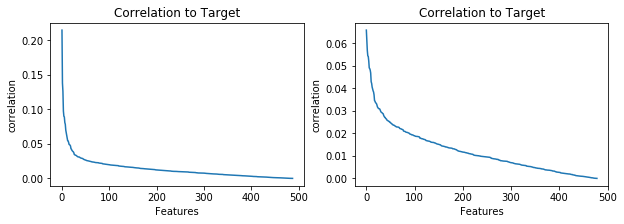

In [115]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(corr_to_target.values[1:])
plt.ylabel('correlation')
plt.xlabel('Features')
plt.title('Correlation to Target')
plt.subplot(122)
plt.plot(corr_to_target.values[10:])
plt.title('Correlation to Target')
plt.ylabel('correlation')
plt.xlabel('Features')
plt.show()

The correlation to target drops off pretty steep at around 25 features. But the first 10 features are numerical features and the rest are the dummies. On the left if we look at just the dummies variables then we can see that the elbow doesnt make a turn until between 150 and 200 features. This is were I will minimize the feature set to. 
Well start with order the features by their correlation to the target and the use sklearn's recursive feature selction tool and use logistic regression as the model for the feature elimination.

In [116]:
# drop correlations that were nan and order feature columns from decending correlation scores
corrl_to_target = dict(corr_to_target.dropna())  
X_train = X_train.loc[:,corrl_to_target.keys()]
X_test = X_test.loc[:,corrl_to_target.keys()]

In [117]:
# drop the target from independent features
X_train.drop('Late_Bus',1,inplace=True)
X_test.drop('Late_Bus',1,inplace=True)

In [118]:
# recusive feature selection using logistic regression 
lr = LogisticRegression(max_iter=300, solver= 'liblinear', warm_start= True)

from sklearn.feature_selection import RFE
# feature extraction
start_time = time.time()

rfe = RFE(lr, n_features_to_select=200)
# fit on train set
fit = rfe.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

# transform train set
recursive_features = fit.transform(X_train)
 

--- 892.0166070461273 seconds ---


In [119]:
X_train = X_train.iloc[:,pd.DataFrame(recursive_features).columns] 
X_test = X_test.iloc[:,pd.DataFrame(recursive_features).columns] 

In [120]:
X_train.shape

(137585, 200)

Next I'll take a look at the heatmap of the correlation matrix to see if any features are highly correlated. If so Well drop one of the correlated features and keep the one that is most highly correlated with the target.

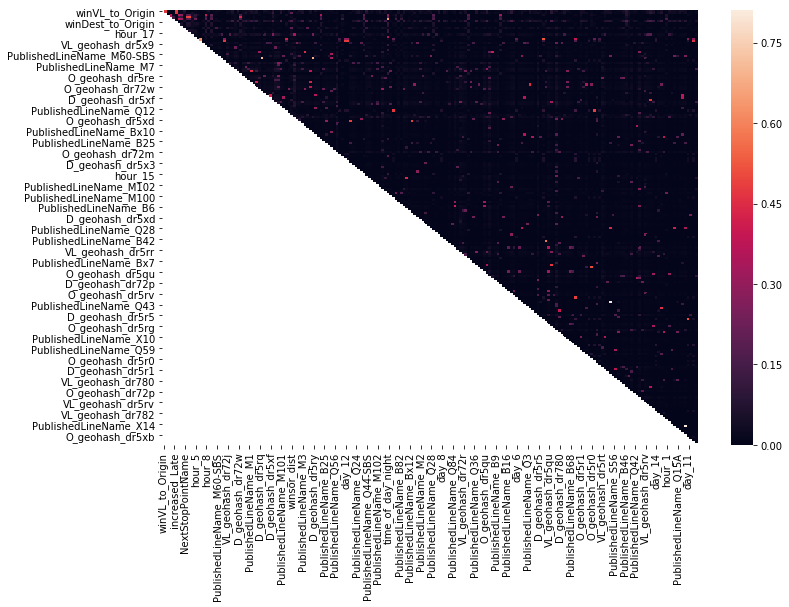

In [121]:
corr_matrix = X_train.corr().abs().where(np.triu(np.ones(X_train.corr().abs().shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

In [122]:
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.50)]
print('Columns to drop: ' , (len(to_drop)))
to_drop

Columns to drop:  11


['hour_17',
 'weekday_Monday',
 'O_geohash_dr5ry',
 'D_geohash_dr5ry',
 'time_of_day_night',
 'weekday_Sunday',
 'PublishedLineName_Bx16',
 'O_geohash_dr5r0',
 'O_geohash_dr781',
 'O_geohash_dr5xb',
 'day_11']

In [123]:
# Drop one of each pair of correlated features
X_train.drop(to_drop,1,inplace=True)
X_test.drop(to_drop,1,inplace=True)


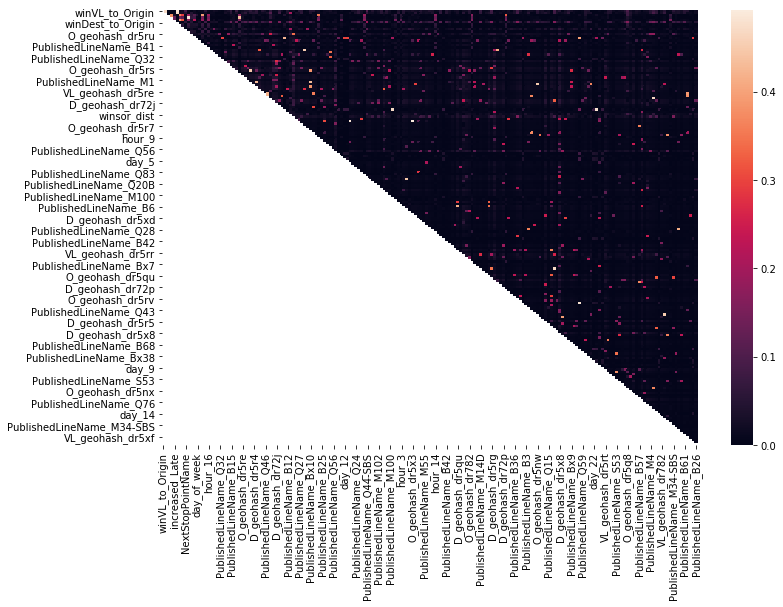

In [124]:
corr_matrix = X_train.corr().abs().where(np.triu(np.ones(X_train.corr().abs().shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

In [125]:
print(X_train.shape) 
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(137585, 189)
(137585,)
(34397, 189)
(34397,)


Since we are dealing with and imbalanced dataset I'll use a random oversampler function to create more random instances of the minority class to balance the training set only.

In [126]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_trainB, y_trainB = ros.fit_sample(X_train, y_train)

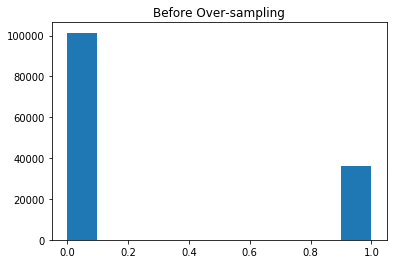

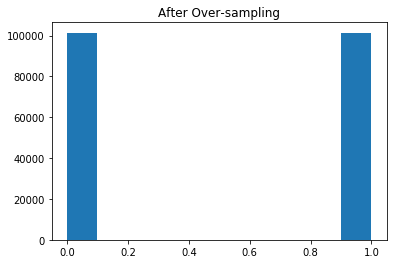

In [127]:
plt.hist(y_train)
plt.title('Before Over-sampling')
plt.show()
plt.hist(y_trainB)
plt.title('After Over-sampling')
plt.show()

In [128]:
# scale the data
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_trainB)
X_trainS = sclr.transform(X_trainB)
X_testS = sclr.transform(X_test)


# Modeling

The metric I want to look at is the recall score since we are looking specifically for late buses. It's better to have misclassified an on-time bus as late than a late-bus as on-time

### Random Forest and Gradient Boost algorithms.

Random_Forest


Consfusion Matrix
col_0         0     1
Late_Bus             
0         22112  3350
1          5627  3308

Classification Report
              precision    recall  f1-score   support

     On-time       0.80      0.87      0.83     25462
        Late       0.50      0.37      0.42      8935

    accuracy                           0.74     34397
   macro avg       0.65      0.62      0.63     34397
weighted avg       0.72      0.74      0.73     34397

Train Score 0.9961190231970964
Test Score 0.7390179376108381
Recall Score 0.370229434806939
AUC: 0.706


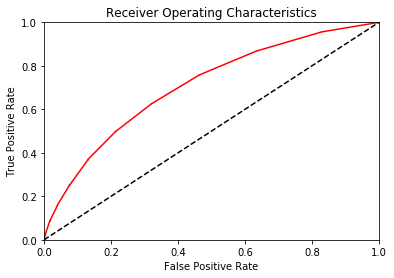

Gradient_Boost


Consfusion Matrix
col_0         0     1
Late_Bus             
0         16800  8662
1          2878  6057

Classification Report
              precision    recall  f1-score   support

     On-time       0.85      0.66      0.74     25462
        Late       0.41      0.68      0.51      8935

    accuracy                           0.66     34397
   macro avg       0.63      0.67      0.63     34397
weighted avg       0.74      0.66      0.68     34397

Train Score 0.6722423859870601
Test Score 0.6645056254905951
Recall Score 0.6778959149412424
AUC: 0.733


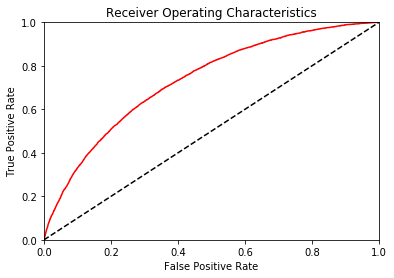

In [129]:
# run random forrest and gradient boost algorithms
base_scores = {}

models = []  
models.append(('Random_Forest' , ensemble.RandomForestClassifier(n_jobs=-1,n_estimators=10,class_weight='balanced'
                                                                 ,random_state=20)))  

models.append(('Gradient_Boost' , ensemble.GradientBoostingClassifier()))
 
 
 
for name ,model in models:
    
    print(str(name))
    print()
    startTime = datetime.now()  
 
    recall_s = Metrics(model, X_trainS , y_trainB, X_testS, y_test) 

    base_scores.update({name:recall_s})

Initally there is overfitting on both models. The AUC scores aren't terrible but the Random Forest is not picking up very many late buses. Possibly tuning the hyperparameter can fix some of these issues.

### Logistic regression alogrithim.

Logistic Regression


Consfusion Matrix
col_0         0     1
Late_Bus             
0         16718  8744
1          2881  6054

Classification Report
              precision    recall  f1-score   support

     On-time       0.85      0.66      0.74     25462
        Late       0.41      0.68      0.51      8935

    accuracy                           0.66     34397
   macro avg       0.63      0.67      0.63     34397
weighted avg       0.74      0.66      0.68     34397

Train Score 0.6688348193151333
Test Score 0.662034479751141
Recall Score 0.6775601566871853
AUC: 0.729


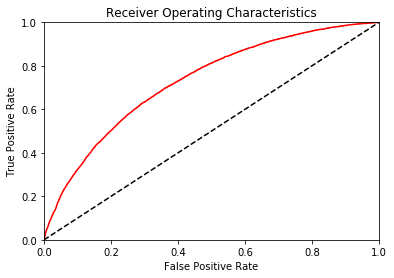

In [130]:
lr = LogisticRegression( solver='liblinear',class_weight='balanced')
AUCscore = {}
Recallscore = {}
 
print('Logistic Regression')
print()
startTime = datetime.now()  

recall_s = Metrics(lr, X_trainS , y_trainB, X_testS, y_test) 

base_scores.update({'Logistic Regression':recall_s})

The first run looks pretty good. The score is still low but it is consistent in the training set, test set and cross validataion. I'll print the first 20 coefficients 

### Tuning hyperparameters using GridsearchCV

In [131]:
# define a function to extract best params from GridsearchCV
from sklearn.model_selection import GridSearchCV
def gridsearch(model, X_trainS , y_trainB, param_grid):    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True,verbose=1,n_jobs=-2)
    grid.fit(X_trainS , y_trainB)
    print(grid.best_params_)
    print(grid.best_score_)
    return grid.best_params_;

#### Random forest

In [132]:
rfc = ensemble.RandomForestClassifier(n_jobs=-1,n_estimators=10,class_weight='balanced',random_state=20)
param_grid = { 'n_estimators': range(2,30),'max_depth' : range(1,10)}
# gridsearch
rfc_best_params = gridsearch(rfc, X_trainS , y_trainB, param_grid)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-2)]: Done 756 out of 756 | elapsed: 16.8min finished


{'max_depth': 9, 'n_estimators': 29}
0.7314311048987593


Random Forest

Consfusion Matrix
col_0         0     1
Late_Bus             
0         16799  8663
1          3034  5901

Classification Report
              precision    recall  f1-score   support

     On-time       0.85      0.66      0.74     25462
        Late       0.41      0.66      0.50      8935

    accuracy                           0.66     34397
   macro avg       0.63      0.66      0.62     34397
weighted avg       0.73      0.66      0.68     34397

Train Score 0.6720106122771027
Test Score 0.6599412739483095
Recall Score 0.6604364857302742
AUC: 0.722


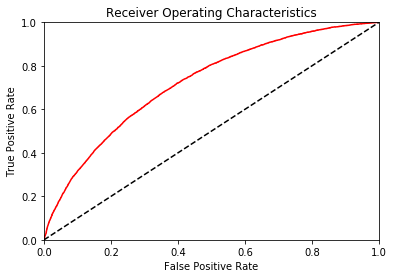

Cross validataion scores: [0.66035503 0.6693787  0.66446395 0.66826117 0.6680146  0.67373508
 0.67033238 0.66880363 0.66658448 0.67462274]


In [133]:
# holds final scores of each alrorithm
final_scores = {}

# run classifer with new params
print('Random Forest')
rfc = ensemble.RandomForestClassifier(**rfc_best_params,random_state=20)
recall_s = Metrics(rfc, X_trainS , y_trainB, X_testS, y_test)
rfc_scores = cross_val_score(rfc, X_trainS, y_trainB, cv=10)
final_scores.update({'Random Forest':recall_s})
print('Cross validataion scores:',rfc_scores)

Not as much  over-fitting and the algorithim is picking up more of the late buses. Let's take a look at the feature importances.

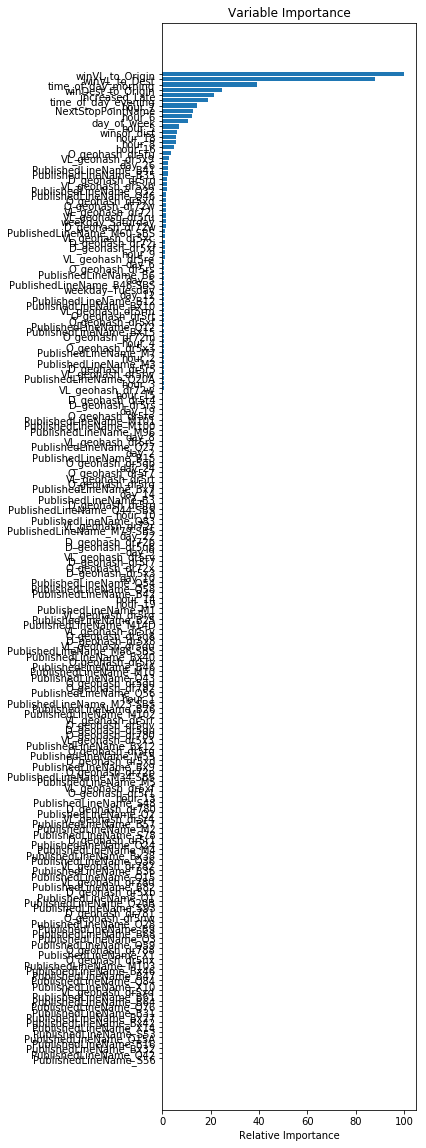

In [134]:
#plot feature importances
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It looks like I could have left out more features in the selection process, however since there hasn't been any modeling of this data set online so there is no benchmark to compare the scores so I'll take no more action and leave it as it is. I'll move on to the other tune the other models.

#### Gradient Boost

In [135]:
clf = ensemble.GradientBoostingClassifier()
param_grid = {'n_estimators':(3,5),'random_state':[20],'learning_rate':np.arange(.05,.1,.01),'max_depth':(2,5,10)}
clf_best_params = gridsearch(clf, X_trainS , y_trainB, param_grid)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed: 19.5min finished


{'learning_rate': 0.09000000000000001, 'max_depth': 10, 'n_estimators': 5, 'random_state': 20}
0.7424353242768227


Gradient Boost

Consfusion Matrix
col_0         0     1
Late_Bus             
0         16540  8922
1          2882  6053

Classification Report
              precision    recall  f1-score   support

     On-time       0.85      0.65      0.74     25462
        Late       0.40      0.68      0.51      8935

    accuracy                           0.66     34397
   macro avg       0.63      0.66      0.62     34397
weighted avg       0.74      0.66      0.68     34397

Train Score 0.6925151885750355
Test Score 0.656830537546879
Recall Score 0.6774482372691663
AUC: 0.721


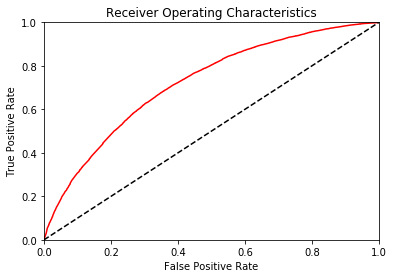

Cross validataion score: [0.66868836 0.67785996 0.67191044 0.67743367 0.6822665  0.68182266
 0.67782819 0.68354867 0.67856791 0.68492948]


In [136]:
# run classifer with new params
print('Gradient Boost')
clf = ensemble.GradientBoostingClassifier(**clf_best_params)
recall_s = Metrics(clf, X_trainS , y_trainB, X_testS, y_test)
clf_scores = cross_val_score(clf, X_trainS, y_trainB, cv=10)

final_scores.update({'Gradient Boost':recall_s})
print('Cross validataion score:',clf_scores)

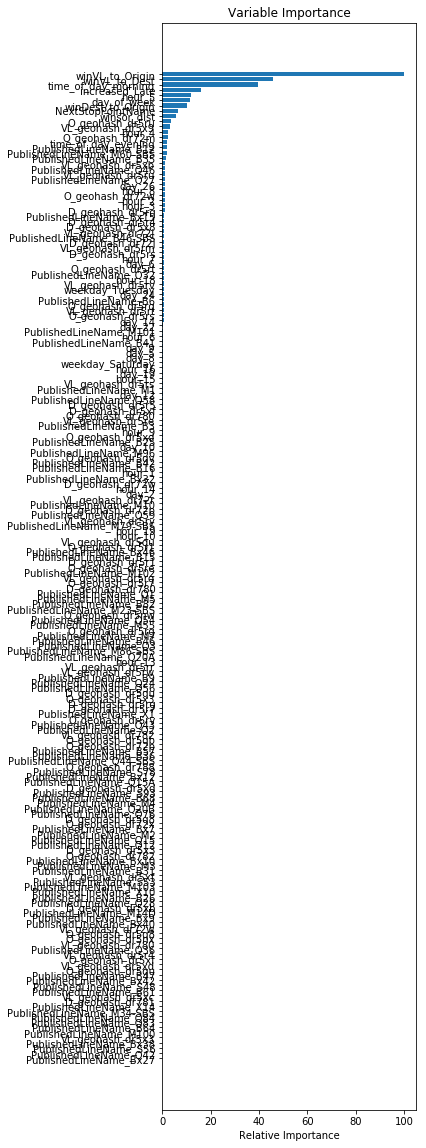

In [137]:
#plot feature importances
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Logistic regression

In [138]:
param_grid = param_grid = {'solver':['sag','lbfgs', 'liblinear'],'max_iter':[1000],  'warm_start' :[True]}
lr_best_params = gridsearch(lr, X_trainS , y_trainB, param_grid)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   6 out of   9 | elapsed:   15.6s remaining:    7.8s
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:   19.9s finished


{'max_iter': 1000, 'solver': 'liblinear', 'warm_start': True}
0.7296110857496851


Logistic Regression

Consfusion Matrix
col_0         0     1
Late_Bus             
0         16718  8744
1          2881  6054

Classification Report
              precision    recall  f1-score   support

     On-time       0.85      0.66      0.74     25462
        Late       0.41      0.68      0.51      8935

    accuracy                           0.66     34397
   macro avg       0.63      0.67      0.63     34397
weighted avg       0.74      0.66      0.68     34397

Train Score 0.6688348193151333
Test Score 0.662034479751141
Recall Score 0.6775601566871853
AUC: 0.729


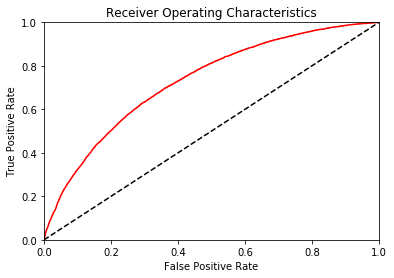

Cross validataion score: [0.66676529 0.6699211  0.66332972 0.67028307 0.66490778 0.66648585
 0.67304468 0.66692968 0.66771871 0.67334057]


In [139]:
# run lr with best params
print('Logistic Regression')
lr = LogisticRegression(**lr_best_params)
lr.fit(X_trainS, y_trainB) 
recall_s = Metrics(lr, X_trainS , y_trainB, X_testS, y_test)
final_scores.update({'Logistic Regression':recall_s})
lr_scores = cross_val_score(lr, X_trainS, y_trainB, cv=10)
print('Cross validataion score:',lr_scores)

In [140]:
LR_coeff_df = { 'Features': X_train.columns,'Coefficients': lr.coef_[0]}
LR_coeff_df = pd.DataFrame(data=LR_coeff_df)
print('First 15 Coefficients')
LR_coeff_df.sort_values(by='Coefficients',ascending=False)[:15]

First 15 Coefficients


,Features,Coefficients
0,winVL_to_Origin,0.296375
8,NextStopPointName,0.136247
5,winDest_to_Origin,0.116266
3,time_of_day_evening,0.105911
17,PublishedLineName_B35,0.105662
18,PublishedLineName_M60-SBS,0.093793
10,O_geohash_dr5ru,0.086981
44,PublishedLineName_B12,0.086942
15,PublishedLineName_B41,0.082741
83,PublishedLineName_B82,0.079071


Next I want to see how LASSO scores hold up compared to the score I got with ordinary feature selection.

### LASSO

In [141]:
modeling_df = mta[['DirectionRef','Late_Bus', 'PublishedLineName',
                   'weekday', 'day_of_week', 'winsor_dist', 'increased_Late',
                   'time_of_day', 'is_midweek','rush_hour',  'winVL_to_Dest', 
                   'winVL_to_Origin','NextStopPointName',
                   'winDest_to_Origin','VL_geohash', 'O_geohash', 'D_geohash','hour','day']] 
 
dummies = ['hour','day','time_of_day', 'VL_geohash', 'O_geohash', 
           'D_geohash','PublishedLineName','weekday']


counts = ['NextStopPointName']

# one-hot-encoding using pandas get_dummies 
modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df 
Y = modeling_df.Late_Bus

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)  
# count encoding 
X_train, X_test = cat_to_count(X_train,X_test,counts) 

X_train.drop('Late_Bus',1,inplace=True)
X_test.drop('Late_Bus',1,inplace=True)

# balance class
import imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=20)
X_trainB, y_trainB = ros.fit_sample(X_train, y_train)
 


# scale
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_trainB)
X_trainS = sclr.transform(X_trainB)
X_testS = sclr.transform(X_test)

In [142]:
Train_Score = []
Test_Score = []
Recall_Score = []
alphas = []
for alpha in np.arange(.0001,.02,.0011):
    lr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=50,C=alpha, warm_start=True)
    lr.fit(X_trainS, y_trainB)
    y_pred = lr.predict(X_testS) 
    print("Train Score",lr.score(X_trainS, y_trainB))
    print("Test Score",lr.score(X_testS, y_test))
    print("Recall Score",recall_score(y_test,y_pred))
    print(alpha)
    Train_Score.append(lr.score(X_trainS, y_trainB))
    Test_Score.append(lr.score(X_testS, y_test))
    Recall_Score.append(recall_score(y_test,y_pred))
    alphas.append(alpha)
    print()
    #Metrics(lr, X_trainS , y_trainB, X_testS, y_test)

Train Score 0.6129329730156226
Test Score 0.6254615228072216
Recall Score 0.5903749300503638
0.0001

Train Score 0.6651609594445321
Test Score 0.6624996365962148
Recall Score 0.6745383324006715
0.0012000000000000001

Train Score 0.671581584345905
Test Score 0.663924179434253
Recall Score 0.6847229994404029
0.0023

Train Score 0.6730659223607385
Test Score 0.6651742884553885
Recall Score 0.6840514829322888
0.0034

Train Score 0.6736034401136184
Test Score 0.6660755298427189
Recall Score 0.6834918858421937
0.0045000000000000005

Train Score 0.6738154884014518
Test Score 0.6667732651103294
Recall Score 0.6831561275881366
0.005600000000000001

Train Score 0.673938772289727
Test Score 0.6672674942582202
Recall Score 0.6831561275881366
0.0067

Train Score 0.6740817816001262
Test Score 0.6673837834694886
Recall Score 0.6828203693340794
0.0078000000000000005

Train Score 0.6740078112671611
Test Score 0.6667732651103294
Recall Score 0.6815892557358701
0.0089

Train Score 0.673978223133975
Test 

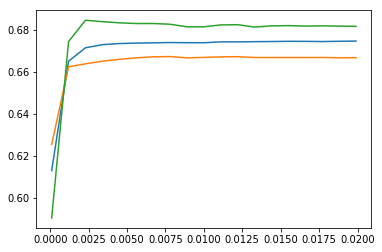

In [143]:
plt.plot(alphas,Train_Score) 
plt.plot(alphas,Test_Score)
plt.plot(alphas,Recall_Score)

LASSO Logistic Regression

Consfusion Matrix
col_0         0     1
Late_Bus             
0         16795  8667
1          2822  6113

Classification Report
              precision    recall  f1-score   support

     On-time       0.86      0.66      0.75     25462
        Late       0.41      0.68      0.52      8935

    accuracy                           0.67     34397
   macro avg       0.63      0.67      0.63     34397
weighted avg       0.74      0.67      0.69     34397

Train Score 0.6733124901372889
Test Score 0.6659883129342675
Recall Score 0.6841634023503078
AUC: 0.734


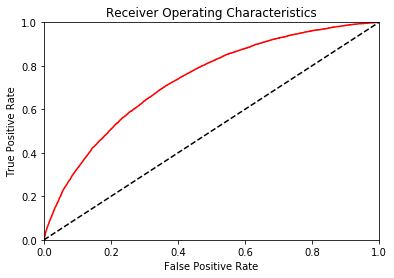

Cross validataion score: [0.66883629 0.67534517 0.66717625 0.67235428 0.66885294 0.67077621
 0.67580629 0.6717625  0.66909952 0.67792682]


In [144]:
print('LASSO Logistic Regression')
LASSO_lr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=20,C=.004, warm_start=True)
recall_s = Metrics(LASSO_lr, X_trainS , y_trainB, X_testS, y_test)

final_scores.update({'LASSO lr':recall_s})
 
LASSO_lr_scores = cross_val_score(LASSO_lr, X_trainS, y_trainB, cv=10)
print('Cross validataion score:',LASSO_lr_scores)

In [145]:
d = { 'Features': X_train.columns,'Coefficients': lr.coef_[0]}
df = pd.DataFrame(data=d)
df.sort_values(by='Coefficients',ascending=False)
coeffs = df[df.Coefficients!=0] 
coeffs[:15]
 

,Features,Coefficients
0,DirectionRef,0.043504
1,day_of_week,0.038826
2,winsor_dist,-0.072668
3,increased_Late,0.040840
4,is_midweek,-0.056121
6,winVL_to_Dest,-0.309054
7,winVL_to_Origin,0.291642
8,NextStopPointName,0.139695
9,winDest_to_Origin,0.232334
10,hour_1,-0.057096


### PCA

In [146]:
modeling_df = mta[['DirectionRef','Late_Bus', 'PublishedLineName',
                   'weekday', 'day_of_week', 'winsor_dist', 'increased_Late',
                   'time_of_day', 'is_midweek','rush_hour',  'winVL_to_Dest', 
                   'winVL_to_Origin','NextStopPointName',
                   'winDest_to_Origin','VL_geohash', 'O_geohash', 'D_geohash','hour','day']] 
 
dummies = ['hour','day','time_of_day', 'VL_geohash', 'O_geohash', 
           'D_geohash','PublishedLineName','weekday']


counts = ['NextStopPointName']

# one-hot-encoding using pandas get_dummies 
modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df 
Y = modeling_df.Late_Bus

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)  
# count encoding 
X_train, X_test = cat_to_count(X_train,X_test,counts) 

X_train.drop('Late_Bus',1,inplace=True)
X_test.drop('Late_Bus',1,inplace=True)

# balance class
ros = RandomOverSampler(random_state=20)
X_trainB, y_trainB = ros.fit_sample(X_train, y_train)
 


# scale
sclr = StandardScaler()
sclr.fit(X_trainB)
X_trainS = sclr.transform(X_trainB)
X_testS = sclr.transform(X_test)

In [147]:
X_train.shape

(137585, 489)

Here I'll plot the explained variance to get the minimum number of PCA components to use as the final feature set.

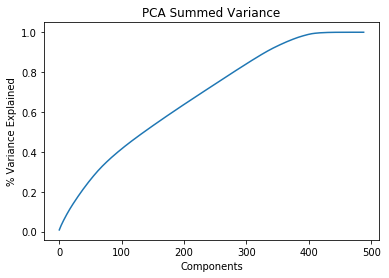

In [148]:
# plot cumulative sum of explained variance
pca = PCA(random_state=20)
pca.fit(X_trainS)  
plt.ylabel('% Variance Explained')
plt.xlabel('Components')
plt.title('PCA Summed Variance') 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

It looks like the percentage of explained variance levels off at around 370 components.

In [149]:
#percentage of varaince explained
np.cumsum(pca.explained_variance_ratio_).max()

0.9999999999999991

In [150]:
# fit and transform with 370 components
pca = PCA(n_components=370,random_state=20)
pca.fit(X_trainS)  
X_train = pca.transform(X_trainS)
X_test = pca.transform(X_testS)

Logistic Regression


C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Consfusion Matrix
col_0         0     1
Late_Bus             
0         16874  8588
1          2845  6090

Classification Report
              precision    recall  f1-score   support

     On-time       0.86      0.66      0.75     25462
        Late       0.41      0.68      0.52      8935

    accuracy                           0.67     34397
   macro avg       0.64      0.67      0.63     34397
weighted avg       0.74      0.67      0.69     34397

Train Score 0.6754970806375257
Test Score 0.6676163618920254
Recall Score 0.6815892557358701
AUC: 0.735


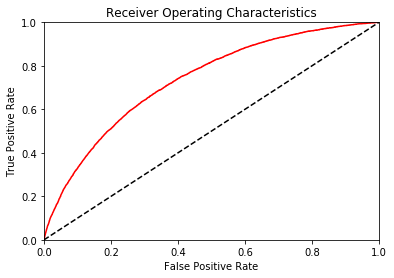

C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: Futur

Cross validataion score: [0.66997041 0.67430966 0.67018444 0.67472137 0.67112141 0.6710721
 0.67506657 0.6751652  0.67048032 0.6805898 ]


In [152]:
# run lr with best params
print('Logistic Regression')
PCA_lr = LogisticRegression()
PCA_lr.fit(X_trainS, y_trainB) 
recall_s = Metrics(PCA_lr, X_trainS , y_trainB, X_testS, y_test)

final_scores.update({'PCA_lr':recall_s})

PCA_lr_scores = cross_val_score(PCA_lr, X_trainS, y_trainB, cv=10)
print('Cross validataion score:',PCA_lr_scores)

In [153]:
base_scores_df = pd.DataFrame([base_scores]).T
base_scores_df.columns = ({'Recall_scores':0})
print('Recall Base Scores')
base_scores_df

Recall Base Scores


,Recall_scores
Gradient_Boost,0.677896
Logistic Regression,0.677560
Random_Forest,0.370229


In [154]:
final_scores_df = pd.DataFrame([final_scores]).T
final_scores_df.columns = ({'Recall_scores':0})
print('Final Recall Scores')
final_scores_df.sort_index()

Final Recall Scores


,Recall_scores
Gradient Boost,0.677448
LASSO lr,0.684163
Logistic Regression,0.677560
PCA_lr,0.681589
Random Forest,0.660436


### Conclusion

Using LASSO linear regression turned out to be just a little bit better than the maually feature selected model. It also beat out PCA by just a hair. Although, I looked at tree based methods linear regression is the best model for this project. It is easier to explain since the coefficients of the model can tell you how a particualr feature affects the prediction. This could help when lookin at specific locations to concentrate efforts to make the bus routes more efficient. 

If MTA found it useful the model probabilities could be adjusted to caprture more of the Late buses at the expense of misclassifying the on-time buses and vice-versa. Below is an example of how that could be achieved. 

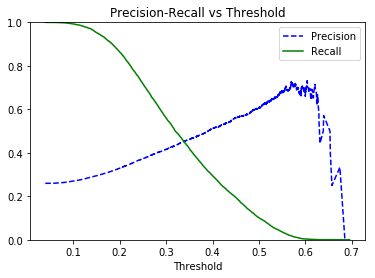

In [155]:
# fuction for prcision recall plot 
def precision_recall_plot (model,X,y):
    y_prob = cross_val_predict(model, X, y, method='predict_proba',cv=10)
    precisions, recalls,thresholds=precision_recall_curve(y, y_prob[:,1])
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.title('Precision-Recall vs Threshold')
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0,1])
precision_recall_plot (LASSO_lr,X_testS,y_test) 
plt.show()

In [156]:
y_prob = lr.predict_proba(X_testS)
y_pred_class = binarize(y_prob,0.49)
y_pred_class = y_pred_class[:,1]
 
 
print('Confusion Matrix with binarized class:')
print(pd.crosstab( y_test,y_pred_class))
print()
print('Classification report with binarized class:') 
print(classification_report(y_test ,y_pred_class))

Confusion Matrix with binarized class:
col_0       0.0   1.0
Late_Bus             
0         16417  9045
1          2680  6255

Classification report with binarized class:
              precision    recall  f1-score   support

           0       0.86      0.64      0.74     25462
           1       0.41      0.70      0.52      8935

    accuracy                           0.66     34397
   macro avg       0.63      0.67      0.63     34397
weighted avg       0.74      0.66      0.68     34397



#### Limitations  and future work 

There are several limitations with the model that should be considered. The first being that the dataset was only from one month, June. Although, there were six million observations they only tell us about the month of June. It would be better to have samples from every month of the year. This way we could look annual patterns such as seasonal traffic and weather. Another imitation is that, because of time, there wasn't much spent on reseaching patterns that effect traffic or into what actually causes a bus to be late in the first place(it may not always be traffic). Data collection on volume of riders in particular areas could possible benificial as well. There is also the matter of the limitations of my local machine to run the algorithms. I would have liked to have used much more of the data if I could have but time and resouces limited me to the small sample that was used. 